In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd
# Provide complete installation or import information for external packages or modules here e.g.

#pip install somepackage
# from somepackage import blah


#!pip install yahoo_fin

import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

#PAST DJIA
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    #"^N225",
    #"^RMCC",
    #"^MID"
]


# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")
        
sandp_time = stock_data["^IXIC"]

/Users/jasonmaytin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
global lumpy_date
lumpy_date = None

def dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val):
    sandp_time.index = pd.to_datetime(sandp_time.index)

    def lump_sum_strategy(df, initial_investment, interval, moving_averages_df):
        total_investment = len(range(interval, len(df), interval)) * initial_investment
        initial_price = df['close'].iloc[0]  # First available closing price at testing start
        shares_owned = total_investment / initial_price  # Total shares bought at once
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(0)  # No additional investment made

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
    def lump_sum_with_delay_strategy(df, initial_investment, interval, moving_averages_df):
        global lumpy_date
        initial_in = len(range(interval, len(df), interval)) * initial_investment
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []
        remaining_investment = 0
        lump_sum_invested = False
        ma_value_peak = moving_averages_df.iloc[0]
        total_investment = 0
        ma_slope = np.gradient(moving_averages_df)

        days = 0
        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']

            if i >= len(df)-interval and not lump_sum_invested:
                shares_bought = initial_in / current_price
                shares_owned += shares_bought
                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(total_investment)
                lump_sum_invested = True
                days = 0
                lumpy_date = df.index[i]
            
            if not lump_sum_invested:
                if i >= 10000 or ((ma_slope[i] > slope_val) and days >= days_val):
                    shares_bought = initial_in / current_price
                    shares_owned += shares_bought
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])
                    investment_history.append(total_investment)
                    lump_sum_invested = True
                    days = 0
                    lumpy_date = df.index[i]
                else:
                    if (ma_slope[i] > 0):
                        days += 1
                    else:
                        days = 0
                    total_investment = 0
            else:
                total_investment = 0

            shares_bought = total_investment / current_price if total_investment > 0 else 0
            shares_owned += shares_bought
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(total_investment)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    def dca_strategy(df, investment_amount, interval):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            shares_bought = investment_amount / current_price
            shares_owned += shares_bought

            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(investment_amount)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    # Calculate moving averages for the testing dataset
    testing_df = sandp_time[start_date:end_date]
    full_set = sandp_time#[training_start_date:testing_end_date]
    moving_averages_test = full_set['close'].rolling(window=moving_average_window).mean()[start_date:end_date]
    
    
    # Calculate the investment strategy results on the testing dataset
    lump_sum_result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    dca_result = dca_strategy(testing_df, initial_investment, time_interval)
    lump_sum_with_delay_result = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    
    # Plotting
    if show_graph:
        plt.figure(figsize=(14, 8))
        plt.plot(testing_df.index, testing_df['close'], label='S&P Close', color='blue')
        plt.plot(testing_df.index, moving_averages_test, label='Moving Average', color='red')

        for date in lump_sum_with_delay_result.index[lump_sum_with_delay_result['investment_history'] > 0]:
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=0.5, label='Investment Dates' if 'Investment Dates' not in plt.gca().get_legend_handles_labels()[1] else "")

        #plt.axvline(x=pd.to_datetime(start_date) + pd.DateOffset(years=1), color='green', linestyle='--', linewidth=0.5, label='Start Date')
        plt.axvline(x=lumpy_date, color='orange', linestyle='--', linewidth=0.5, label='Lump Sum Date')
        #print(start_date)
        #print(lumpy_date)
            
        plt.title('S&P Close and Moving Average Over Time')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        # Plot DCA Strategy Performance
        fig, ax1 = plt.subplots(figsize=(14, 8))

        ax1.bar(lump_sum_with_delay_result.index.strftime('%Y-%m-%d'), lump_sum_with_delay_result['investment_history'], color='orange', label='Individual Investments')

        ax2 = ax1.twinx()

        ax2.plot(lump_sum_with_delay_result.index.strftime('%Y-%m-%d'), lump_sum_with_delay_result['portfolio_value'], label='Lump Sum w/ Delay Portfolio Value', color='blue')
        ax2.plot(dca_result.index.strftime('%Y-%m-%d'), dca_result['portfolio_value'], label='DCA Portfolio Value', color='red')
        ax2.plot(lump_sum_result.index.strftime('%Y-%m-%d'), lump_sum_result['portfolio_value'], label='Lump Sum Portfolio Value', color='black')
        
        ax1.set_title('Portfolio Value and Individual Investments Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Individual Investments')
        ax2.set_ylabel('Portfolio Value')
        ax1.xaxis.set_tick_params(rotation=45)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper center')
        
        tick_frequency = 10
        ax1.xaxis.set_ticks(lump_sum_with_delay_result.index.strftime('%Y-%m-%d')[::tick_frequency])

        plt.show()

    lump_sum_with_delay_value = lump_sum_with_delay_result["portfolio_value"][-1]
    dca_value = dca_result["portfolio_value"][-1]
    lump_sum_value = lump_sum_result["portfolio_value"][-1]

    return [lump_sum_with_delay_value, dca_value, lump_sum_value,lumpy_date]

In [3]:
from datetime import datetime, timedelta

start_dates = np.random.choice(sandp_time.loc['2000-01-01':'2024-04-26'].index, size=2000, replace=False)
end_dates = [date + pd.DateOffset(years=1) for date in start_dates]  # 6 years later

# Parameters
moving_average_window = 200
time_interval = 5
initial_investment = 10000
show_graph = False
slope_val = 0.001
days_val = 2

# Collect results
results = []
for start_date, end_date in zip(start_dates, end_dates):
    try:
        result = dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val)
        result_with_dates = result + [start_date, end_date]  # Append start and end dates to the result
        results.append(result_with_dates)
    except:
        pass

# Convert results into a DataFrame for easier manipulation
results_df = pd.DataFrame(results, columns=['Lump Sum with Delay', 'DCA', 'Lump Sum', 'Lump Sum Date','Start Date', 'End Date'])
results_df['Best Strategy'] = results_df[['Lump Sum with Delay', 'DCA', "Lump Sum"]].idxmax(axis=1)

In [4]:
results_df

Lump Sum with Delay            DCA       Lump Sum Lump Sum Date  \
0           555542.321588  576127.066530  573735.276855    2010-04-16   
1           762417.937575  621672.534669  802780.780618    2020-05-11   
2           544647.372742  554497.523581  547025.313587    2012-04-25   
3           752662.030178  627890.238698  743698.367380    2020-04-24   
4           555724.977532  577375.673062  520733.683130    2023-04-14   
...                   ...            ...            ...           ...   
1994        506701.769606  494839.919248  517033.226618    2005-07-08   
1995        508018.932279  490746.943827  497927.430544    2007-01-26   
1996        500515.608540  475568.859362  495759.744080    2021-03-15   
1997         10000.000000   20018.733144   10018.733144    2024-04-24   
1998        514847.957570  546236.733125  607149.223869    2004-11-26   

     Start Date   End Date        Best Strategy  
0    2010-04-01 2011-04-01                  DCA  
1    2020-04-27 2021-04-27             Lump Sum  
2    2012-04-11 2013-04-11                  DCA  
3    2020-03-05 2021-03-05  Lump Sum with Delay  
4    2022-08-17 2023-08-17                  DCA  
...         ...        ...                  ...  
1994 2005-06-23 2006-06-23             Lump Sum  
1995 2007-01-11 2008-01-11  Lump Sum with Delay  
1996 2021-03-01 2022-03-01  Lump Sum with Delay  
1997 2024-04-17 2025-04-17                  DCA  
1998 2004-08-11 2005-08-11             Lump Sum  

[1999 rows x 7 columns]

In [27]:
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

def generate_features(data):
    features = pd.DataFrame(index=data.index)
    features['close'] = data['close']
    features['moving_average'] = data['close'].rolling(window=200).mean()
    features['volatility'] = data['close'].rolling(window=200).std()
    features['momentum'] = data['close'].pct_change(periods=10)
    features.dropna(inplace=True)  # Drop rows with NaN values which are result of rolling function
    return features

# Prepare dataset
features = generate_features(sandp_time)
results = pd.DataFrame(results_df, columns=['Start Date', 'End Date', 'Lump Sum with Delay', 'DCA', 'Lump Sum', 'Best Strategy', 'Lump Sum Date'])

# Merge features with results
data = features.join(results['Best Strategy']).dropna()
feature_periods = []

for idx, row in results.iterrows():
    #period_features = features.loc[row['Start Date']:row['End Date']]
    
    new_date = row['Lump Sum Date'] - timedelta(days=365 * 1)
    period_features = features.loc[new_date:row['Lump Sum Date']]
    
    #period_features["close"] = MinMaxScaler().fit_transform(period_features[["close"]])
    #period_features["moving_average"] = MinMaxScaler().fit_transform(period_features[["moving_average"]])
    #period_features["volatility"] = MinMaxScaler().fit_transform(period_features[["volatility"]])
    #period_features["momentum"] = MinMaxScaler().fit_transform(period_features[["momentum"]])
    feature_periods.append(period_features)
    
results["data"] = pd.DataFrame(feature_periods)
#results = results[results["Best Strategy"] != "DCA"]
#results = results.reset_index(drop=True)
results[["Lump Sum with Delay", "DCA", "Lump Sum"]] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(pd.to_numeric, errors='coerce')
results["ratio"] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].max(axis=1) / results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(lambda x: x.nlargest(2).iloc[-1], axis=1)
results = results[results["ratio"] > 1.09]

In [28]:
results

Start Date   End Date  Lump Sum with Delay            DCA       Lump Sum  \
7    2000-10-25 2001-10-25        490000.000000  400318.184616  259154.983713   
12   2000-11-02 2001-11-02        490000.000000  395182.620421  238269.509100   
14   2003-02-07 2004-02-07        662711.444556  614693.361197  787371.285382   
15   2024-04-08 2025-04-08         20000.000000   29233.150835   19012.363273   
17   2022-09-29 2023-09-29        544451.405876  557284.965252  614727.276696   
...         ...        ...                  ...            ...            ...   
1984 2010-08-27 2011-08-27        523741.072058  479328.924790  572914.120736   
1988 2003-03-17 2004-03-17        651282.078398  576681.876005  712767.621448   
1990 2000-06-06 2001-06-06        268594.129848  394681.722038  286969.849134   
1997 2024-04-17 2025-04-17         10000.000000   20018.733144   10018.733144   
1998 2004-08-11 2005-08-11        514847.957570  546236.733125  607149.223869   

            Best Strategy Lump Sum Date  \
7     Lump Sum with Delay    2001-10-22   
12    Lump Sum with Delay    2001-10-30   
14               Lump Sum    2003-05-06   
15                    DCA    2024-04-22   
17               Lump Sum    2023-04-14   
...                   ...           ...   
1984             Lump Sum    2010-09-20   
1988             Lump Sum    2003-05-06   
1990                  DCA    2000-06-20   
1997                  DCA    2024-04-24   
1998             Lump Sum    2004-11-26   

                                                   data     ratio  
7                       close  moving_average  volat...  1.224026  
12                      close  moving_average  volat...  1.239933  
14                      close  moving_average  volat...  1.188106  
15                       close  moving_average   vol...  1.461658  
17                       close  moving_average  vola...  1.103075  
...                                                 ...       ...  
1984                    close  moving_average  volat...  1.093888  
1988                    close  moving_average  volat...  1.094407  
1990                    close  moving_average  volat...  1.375342  
1997                     close  moving_average   vol...  1.998130  
1998                    close  moving_average  volat...  1.111513  

[409 rows x 9 columns]

In [29]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np


def flatten_features(df_list):
    return pd.concat([df.stack().reset_index(drop=True) for df in df_list], axis=1).T


flat_features = flatten_features(results['data']).dropna(axis=1)
labels = results['Best Strategy']

X_train, X_test, y_train, y_test = train_test_split(flat_features, labels, test_size=0.3, random_state=42)

svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_reduced, y_train)

y_train_pred = classifier.predict(X_train_reduced)
y_pred = classifier.predict(X_test_reduced)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy of the model: {train_accuracy}")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy of the model: {test_accuracy}")

Training accuracy of the model: 0.9230769230769231
Test accuracy of the model: 0.8943089430894309


In [30]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions
y_train_pred = classifier.predict(X_train)
y_pred = classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training accuracy of the model: {train_accuracy}")
print(f"Test accuracy of the model: {test_accuracy}")

len(results)

Training accuracy of the model: 0.9230769230769231
Test accuracy of the model: 0.9186991869918699


409

In [177]:
print("{:<30} {:}".format("True", "Prediction"))
print("")
for i, j in zip(list(y_test), y_pred):
    print("{:<30} {:}".format(i, j))

True                           Prediction

Lump Sum                       Lump Sum
DCA                            DCA
DCA                            Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
DCA                            Lump Sum
Lump Sum                       Lump Sum
DCA                            DCA
DCA                            DCA
DCA                            DCA
DCA                            DCA
DCA                            DCA
DCA                            DCA
DCA                            DCA
DCA                            DCA
DCA                            DCA
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum with Delay            Lump Sum with Delay
DCA                            Lump Sum
DCA                            DCA
Lump Sum                       DCA
Lump Sum                       Lump Sum
DCA   

In [31]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

                     precision    recall  f1-score   support

                DCA       0.96      0.88      0.92        57
           Lump Sum       0.85      0.96      0.90        47
Lump Sum with Delay       1.00      0.95      0.97        19

           accuracy                           0.92       123
          macro avg       0.94      0.93      0.93       123
       weighted avg       0.92      0.92      0.92       123



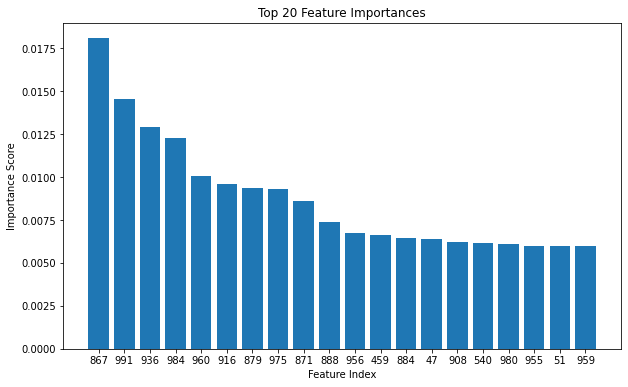

In [32]:
feature_importances = classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot first 50 feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), feature_importances[indices[:20]], align="center")
plt.xticks(range(20), indices[:20])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

[825, 181, 1864, 1646, 1205, 1825, 943, 1405, 1175, 62, 1509, 1572, 516, 396, 1680, 1780, 235, 1658, 220, 752, 1785, 1984, 1738, 296, 120, 81, 793, 1275, 1375, 941, 711, 20, 243, 419, 513, 1248, 836, 1988, 1943, 874, 453, 524, 29, 1798, 1747]


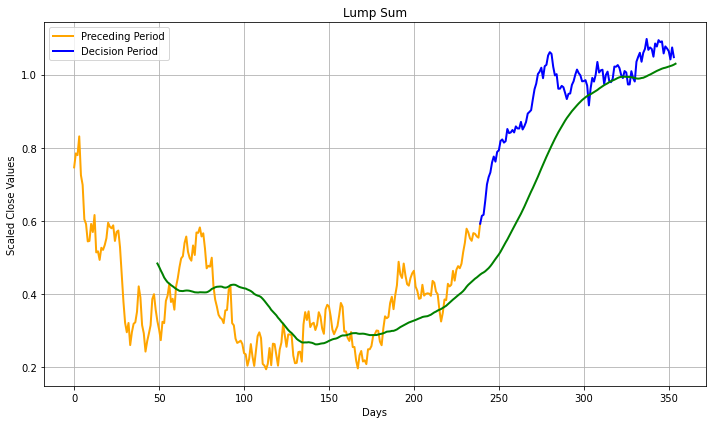

[1693, 42, 7, 289, 247, 1856, 527, 575, 1145, 1927, 67, 337, 720, 542, 1968, 1928, 1514, 378]


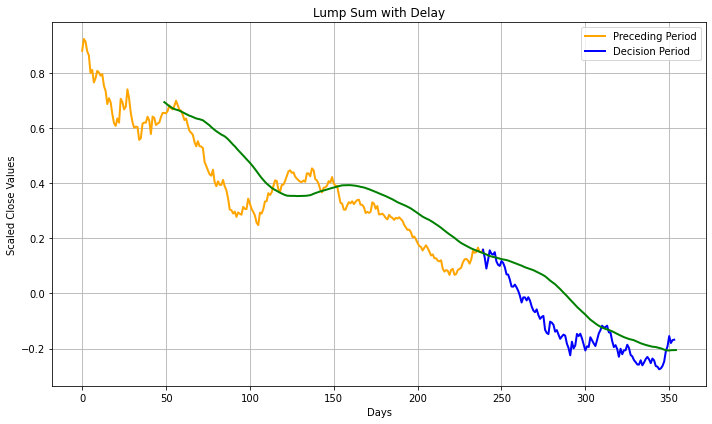

[638, 583, 431, 353, 1134, 1161, 617, 1424, 414, 1766, 377, 375, 159, 363, 979, 484, 1931, 1033, 1249, 1325, 1084, 1907, 1840, 1337, 346, 385, 134, 789, 114, 1190, 373, 1694, 895, 171, 1916, 1788, 1420, 15, 85, 316, 1430, 839, 1876, 616, 976, 1865, 1312, 97, 1495, 308]


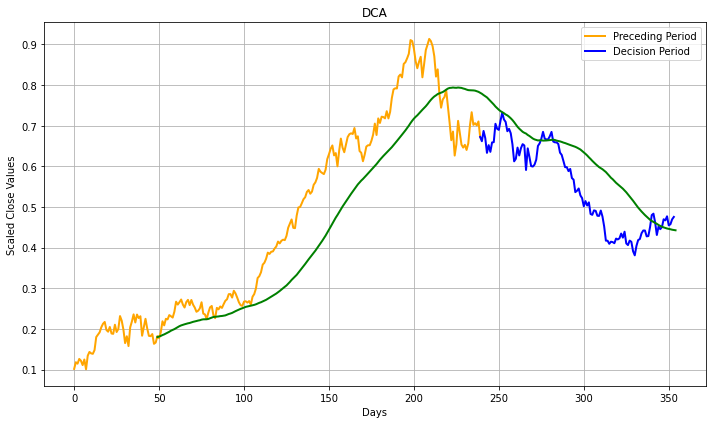

In [33]:
for strategy in ["Lump Sum", "Lump Sum with Delay", "DCA"]:
#for strategy in ["Lump Sum"]:
#for strategy in ["Lump Sum with Delay"]:
#for strategy in ["DCA"]:
    matching_delay_indices = []
    resetted_index = y_test.reset_index()

    # Iterate over the indices and the values of y_test and y_pred
    for idx, (actual, predicted) in enumerate(zip(y_test, y_pred)):
        if actual == predicted == strategy:
            matching_delay_indices.append(resetted_index.loc[idx]["index"])
    print(matching_delay_indices)

    start_dates = [results.loc[i]["Start Date"] for i in matching_delay_indices]
    end_dates = [results.loc[i]["End Date"] for i in matching_delay_indices]
    lump_sum_dates = [results.loc[i]["Lump Sum Date"] for i in matching_delay_indices] 
    show_graph = True

    final_1 = [0.5] * 240  # Initialize final variable for the first line
    final_2 = [0.5] * 115  # Initialize final variable for the second line

    for start_date, end_date, lump_sum_date in zip(start_dates, end_dates, lump_sum_dates):
        new_date = (lump_sum_date - timedelta(days=365 * 1))
        data = sandp_time['close'][new_date:lump_sum_date]
        scaled = (data - data.min()) / (data.max() - data.min())
        scaled = np.array(scaled)[len(scaled)-240:]
        final_1 = (final_1 + scaled) / 2  # Aggregate with the first final variable

        # Calculate the second final variable
        end_data = sandp_time['close'][lump_sum_date:lump_sum_date + timedelta(days=365 * 1)]
        #print(len(end_data))
        scaled_end = (end_data - end_data.min()) / (end_data.max() - end_data.min())
        scaled_end = np.array(scaled_end)[len(scaled_end)-115:]
        if len(scaled_end) == 115:
            final_2 = (final_2 + scaled_end) / 2  # Aggregate with the second final variable


    # Plot the first line
    final_2 = final_2+(final_1[-1]-final_2[0])
    
    plt.figure(figsize=(10, 6))
    plt.plot(final_1, color='orange', linewidth=2, linestyle='-')
    
    # Plot the second line
    plt.plot(range(len(final_1) - 1, len(final_1) + len(final_2) - 1), final_2, color='blue', linewidth=2, linestyle='-')

    combined_final = np.concatenate([final_1,final_2])
    moving_average = pd.Series(combined_final).rolling(window=50).mean()
    plt.plot(moving_average, color='green', linestyle='-', linewidth=2)

    
    plt.title(strategy)
    plt.xlabel('Days')
    plt.ylabel('Scaled Close Values')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(['Preceding Period', 'Decision Period'], loc='best')
    plt.show()

Initial Date : 2001-01-23
Start Date   : 2001-07-12 00:00:00
Lump Sum Date: 2002-01-23
End Date     : 2002-07-12


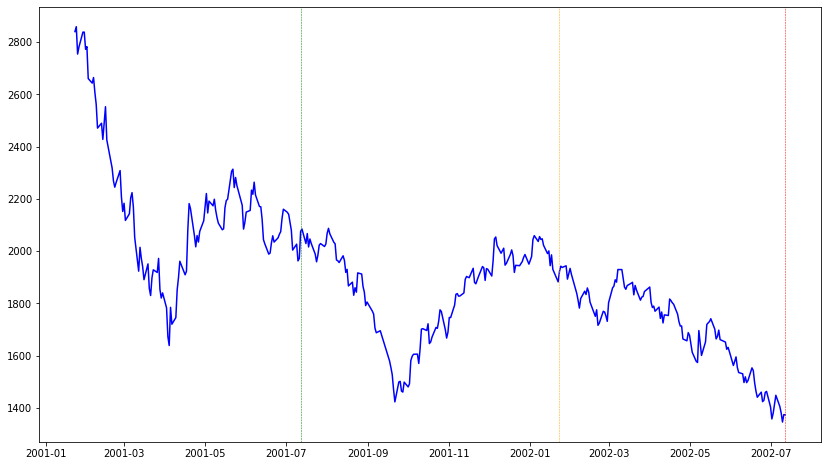

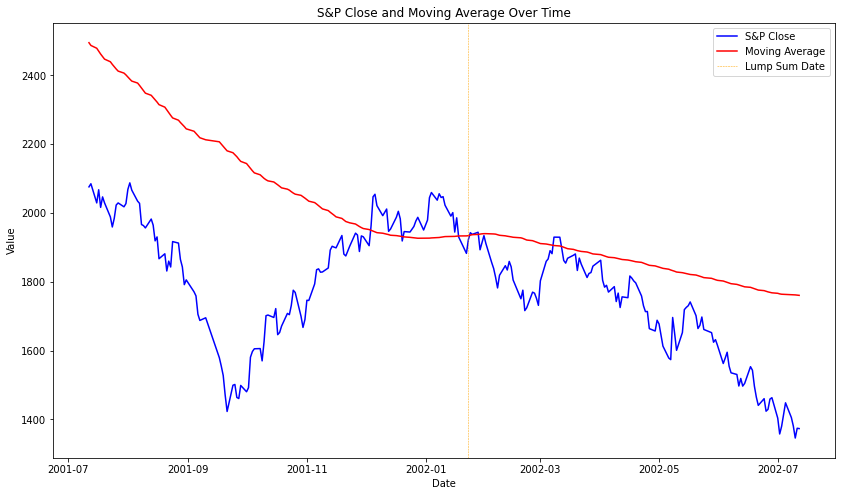

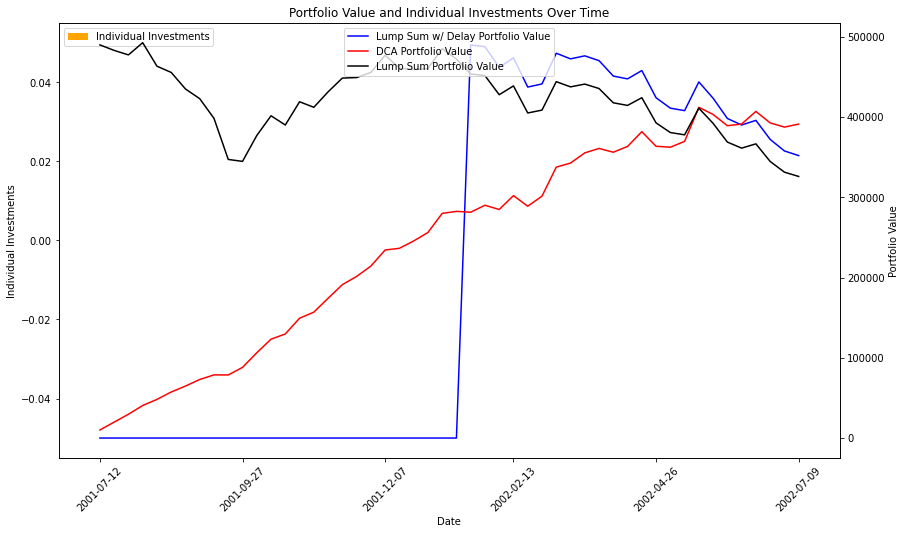

Initial Date : 2020-12-23
Start Date   : 2021-12-09 00:00:00
Lump Sum Date: 2021-12-23
End Date     : 2022-12-09


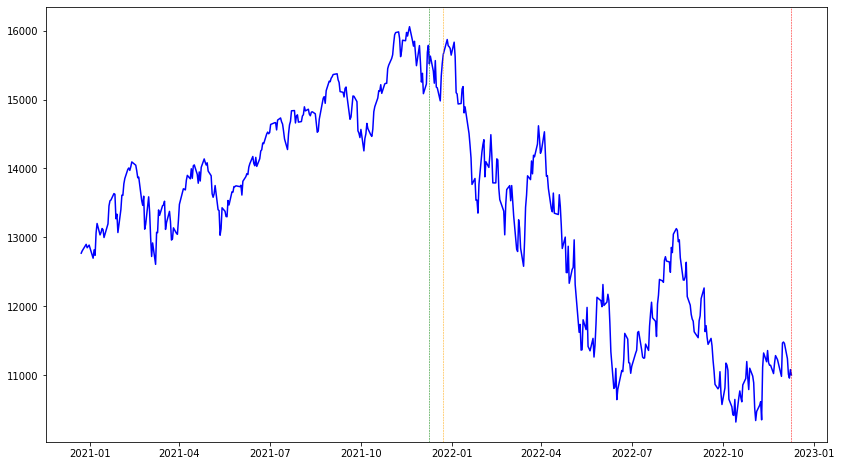

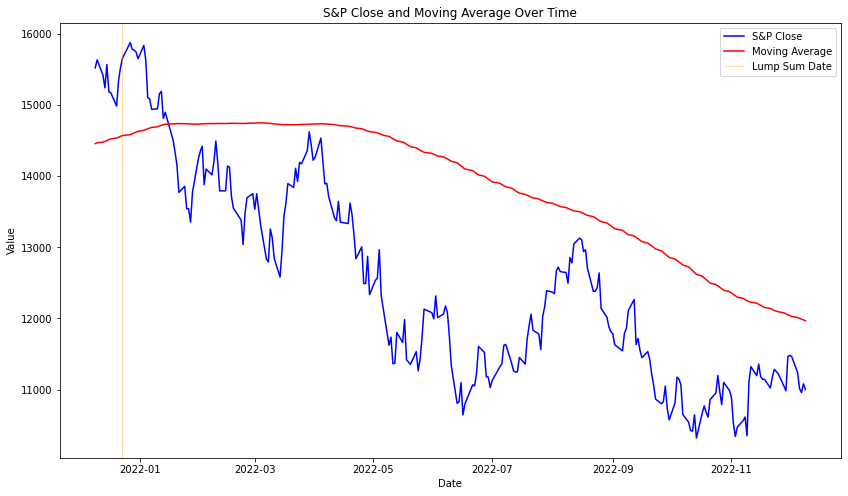

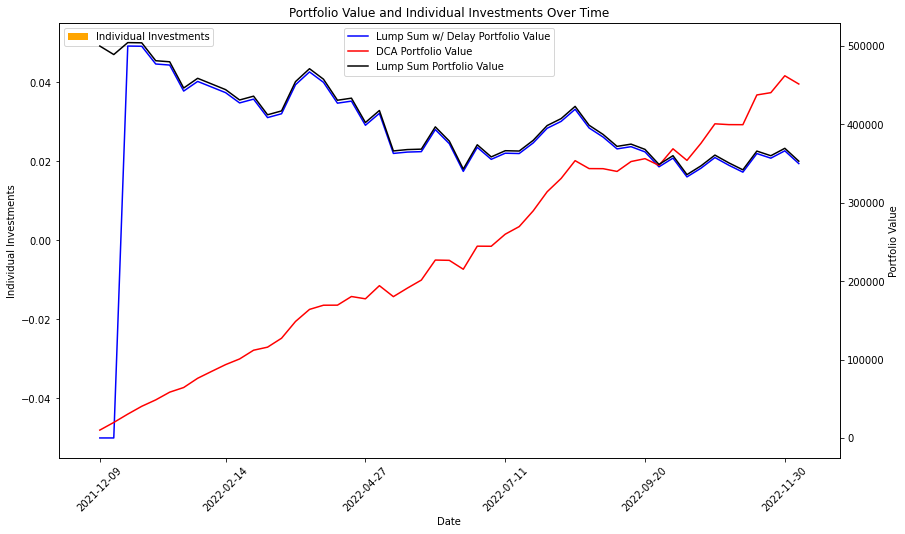

Initial Date : 2001-01-18
Start Date   : 2001-12-27 00:00:00
Lump Sum Date: 2002-01-18
End Date     : 2002-12-27


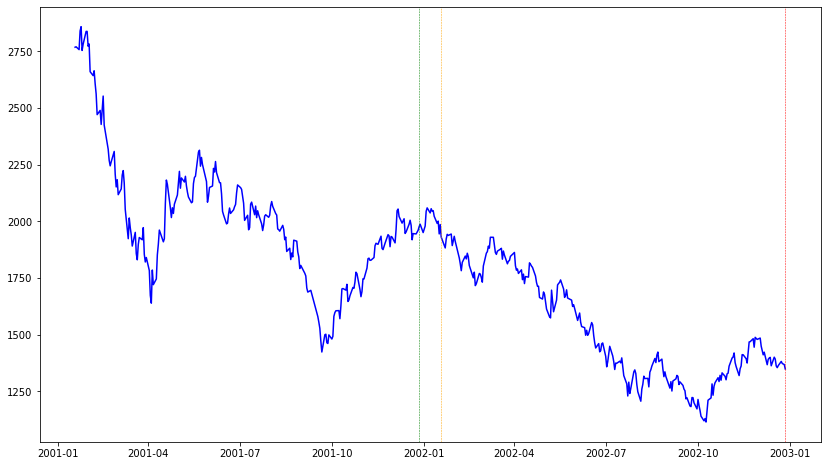

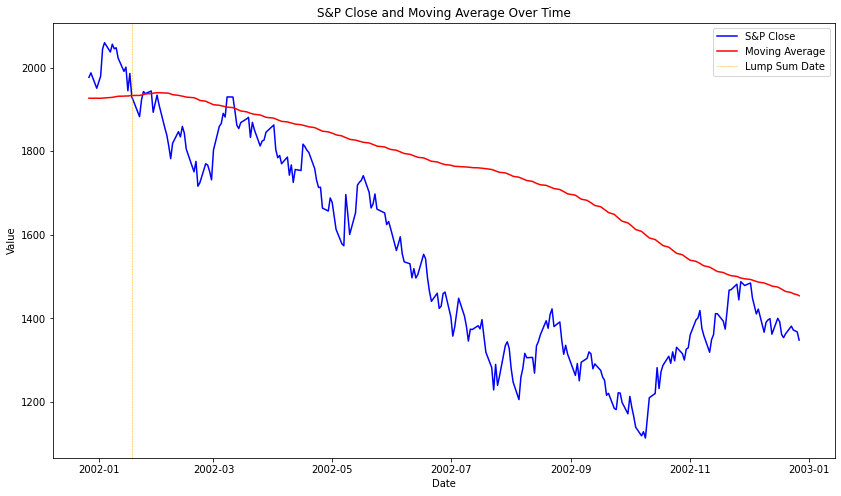

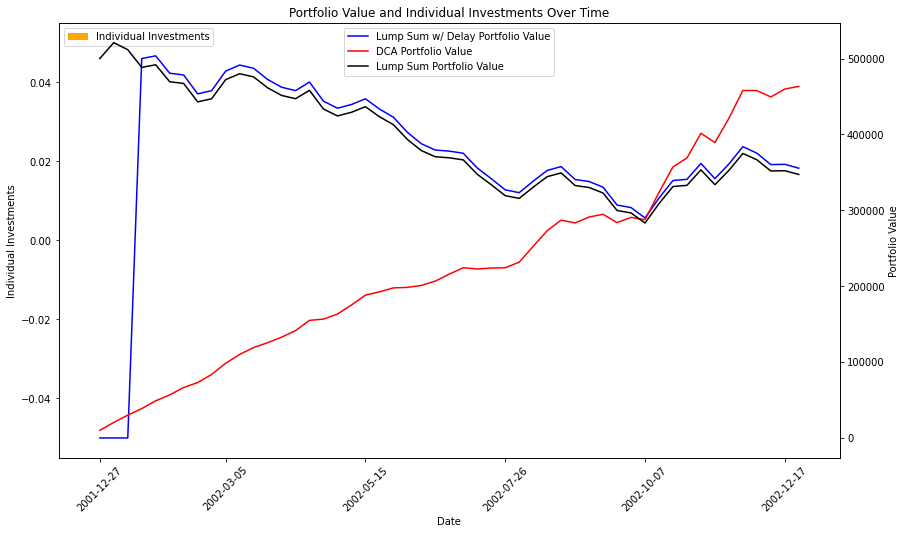

Initial Date : 1999-01-28
Start Date   : 2000-01-13 00:00:00
Lump Sum Date: 2000-01-28
End Date     : 2001-01-13


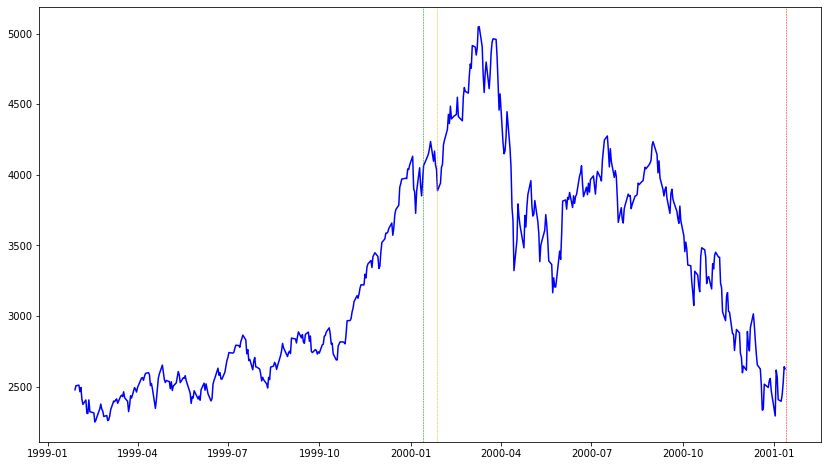

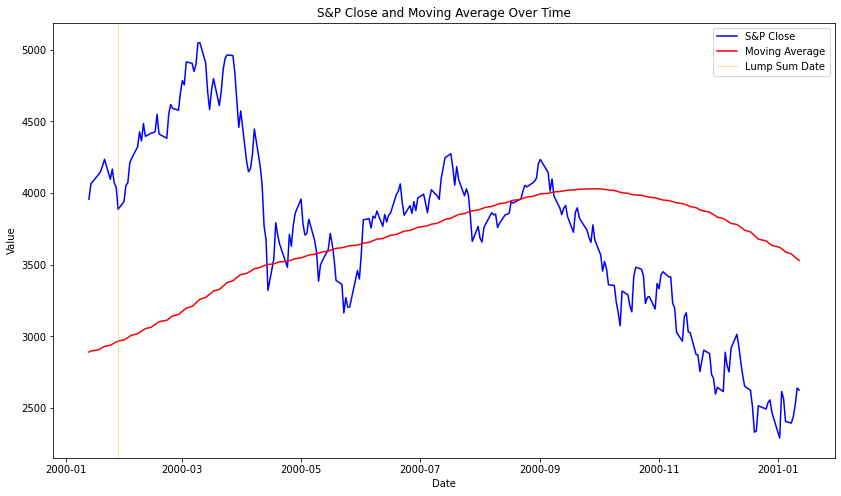

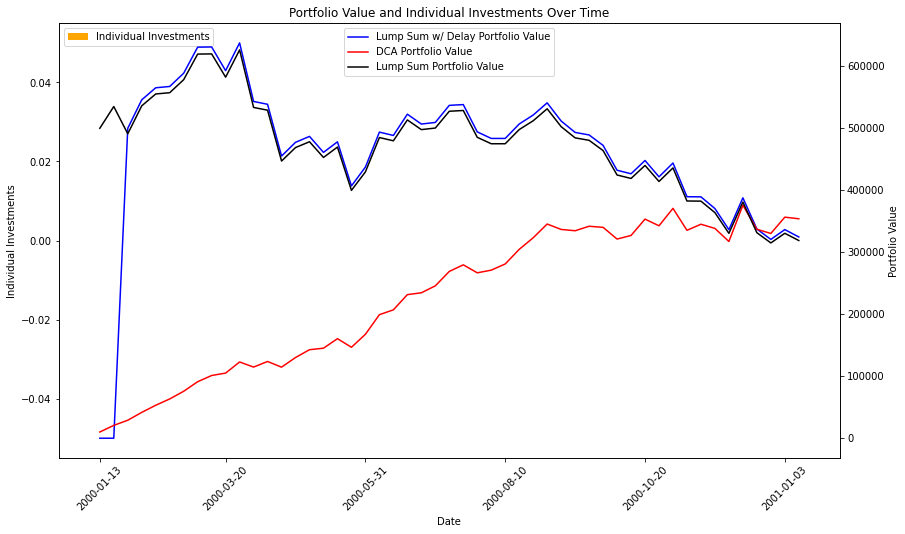

Initial Date : 2001-01-16
Start Date   : 2001-12-24 00:00:00
Lump Sum Date: 2002-01-16
End Date     : 2002-12-24


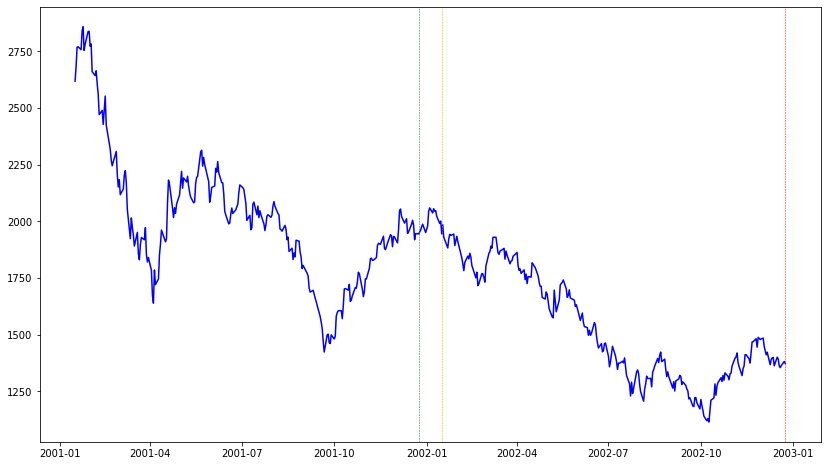

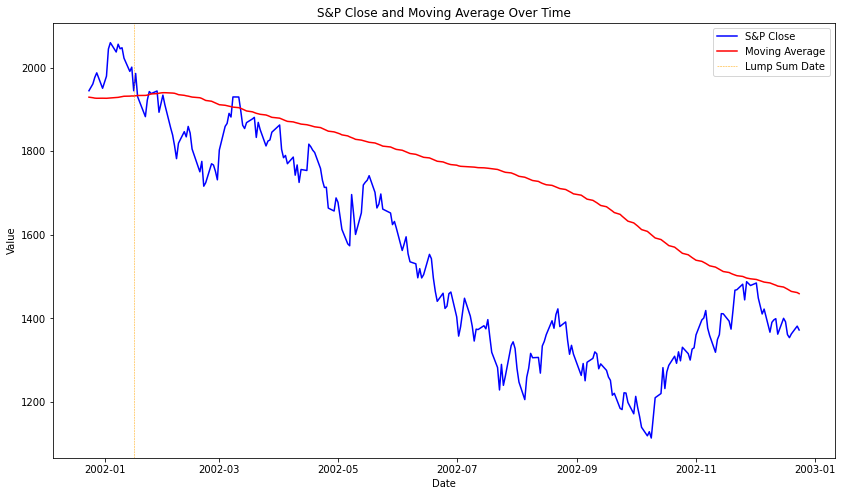

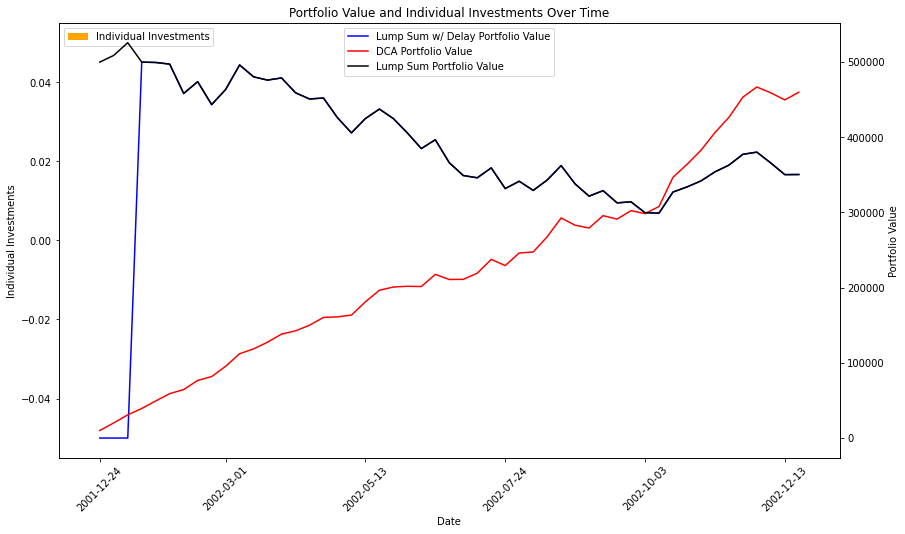

Initial Date : 2001-01-22
Start Date   : 2001-12-13 00:00:00
Lump Sum Date: 2002-01-22
End Date     : 2002-12-13


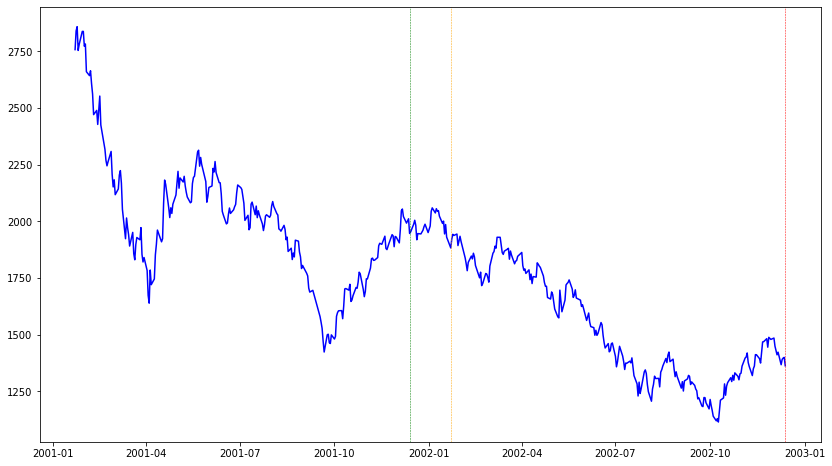

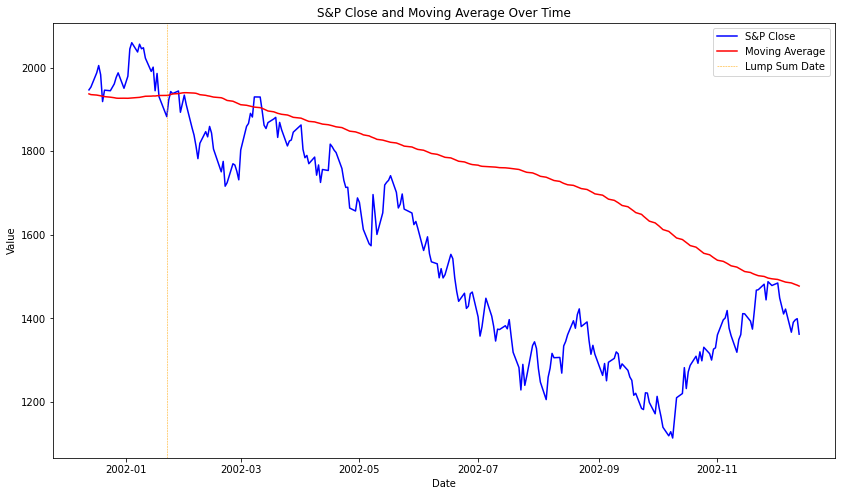

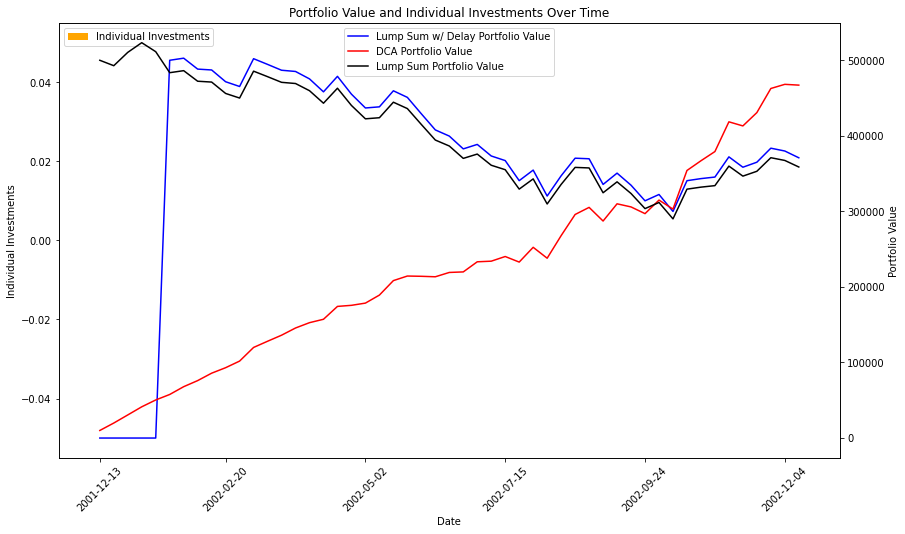

Initial Date : 1999-07-06
Start Date   : 2000-06-20 00:00:00
Lump Sum Date: 2000-07-05
End Date     : 2001-06-20


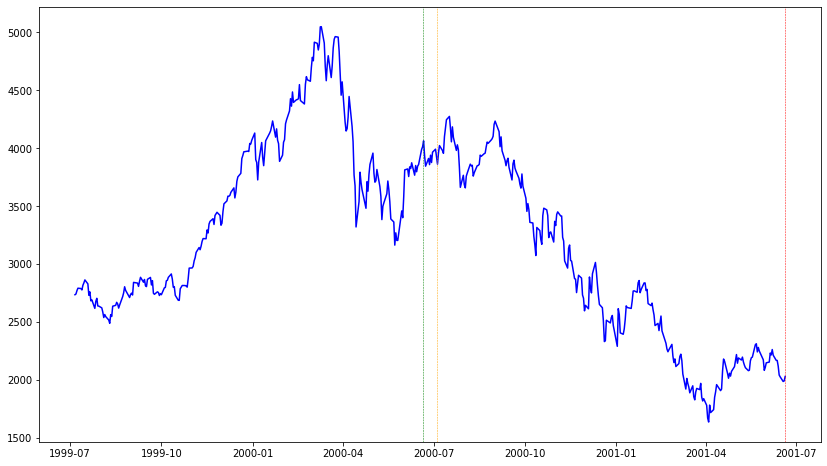

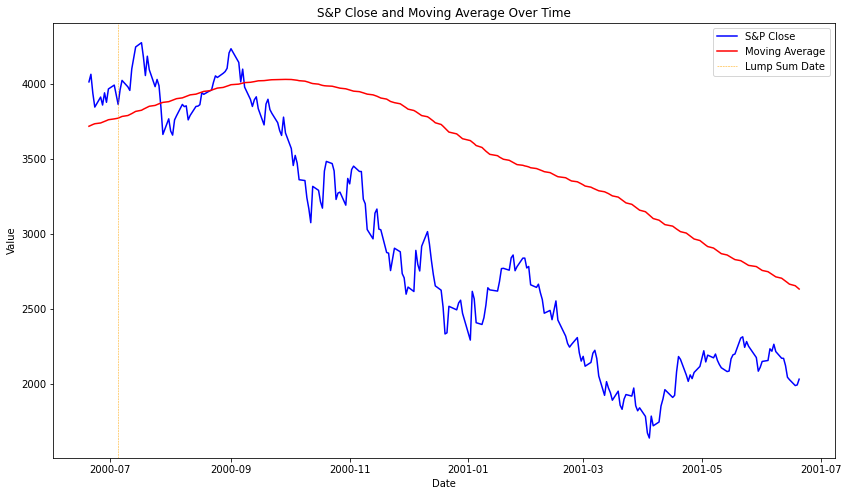

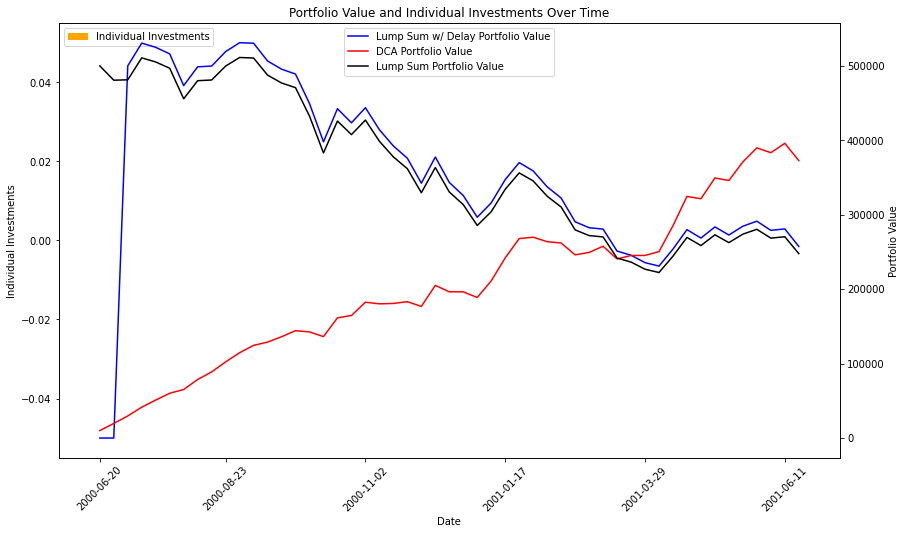

Initial Date : 2006-12-28
Start Date   : 2007-12-13 00:00:00
Lump Sum Date: 2007-12-28
End Date     : 2008-12-13


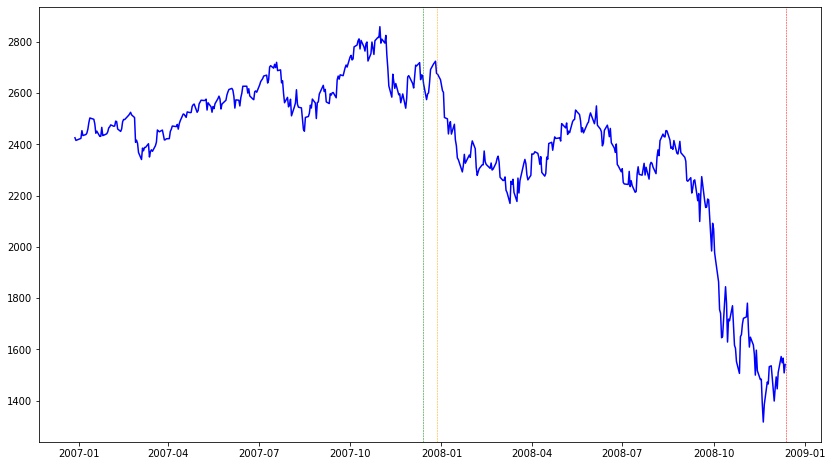

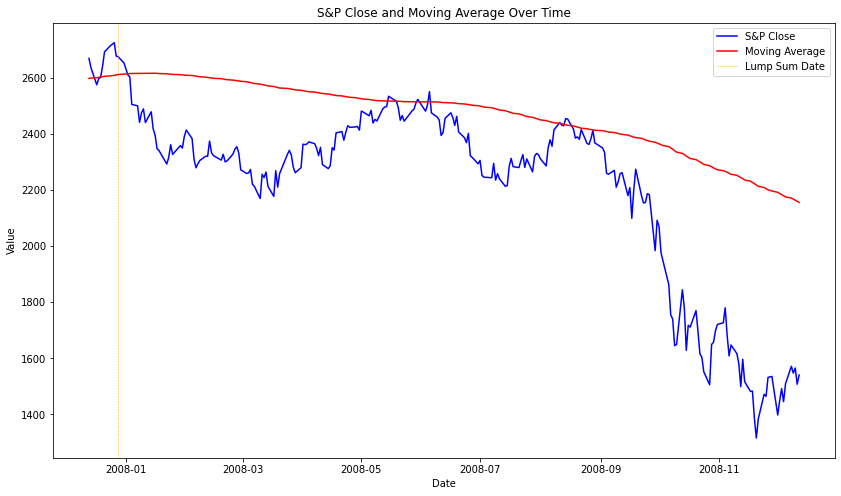

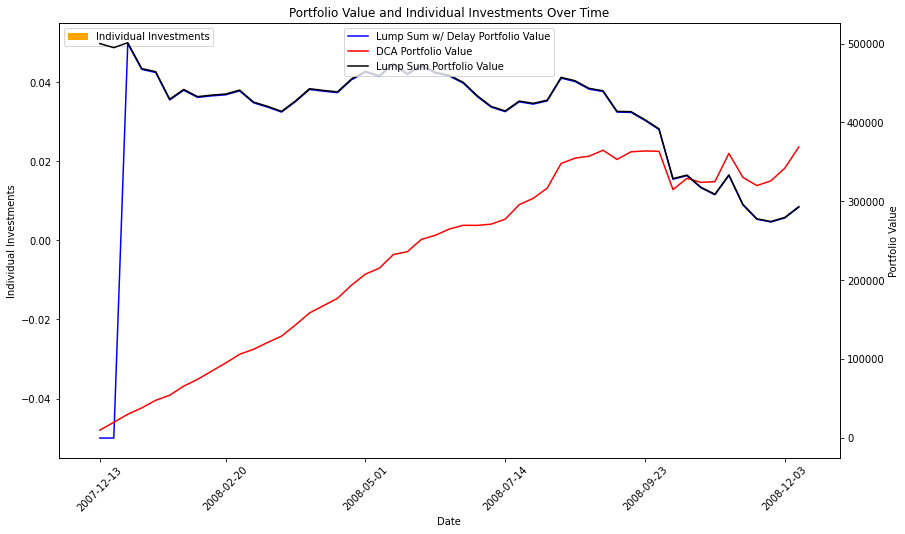

Initial Date : 2023-04-10
Start Date   : 2024-03-25 00:00:00
Lump Sum Date: 2024-04-09
End Date     : 2025-03-25


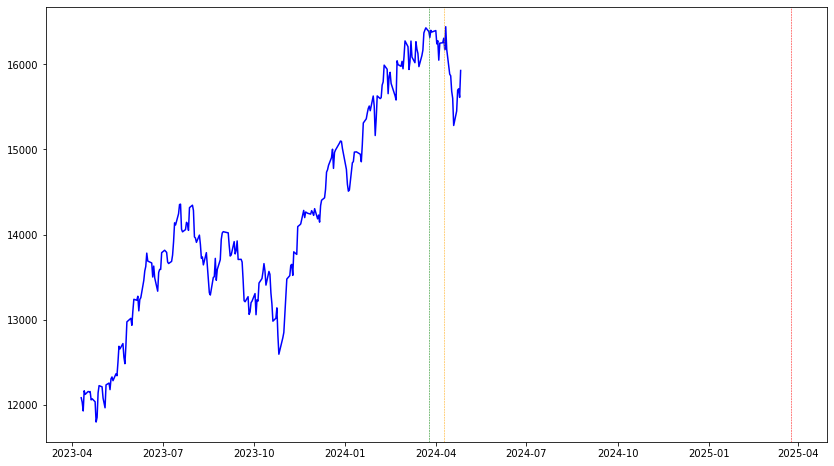

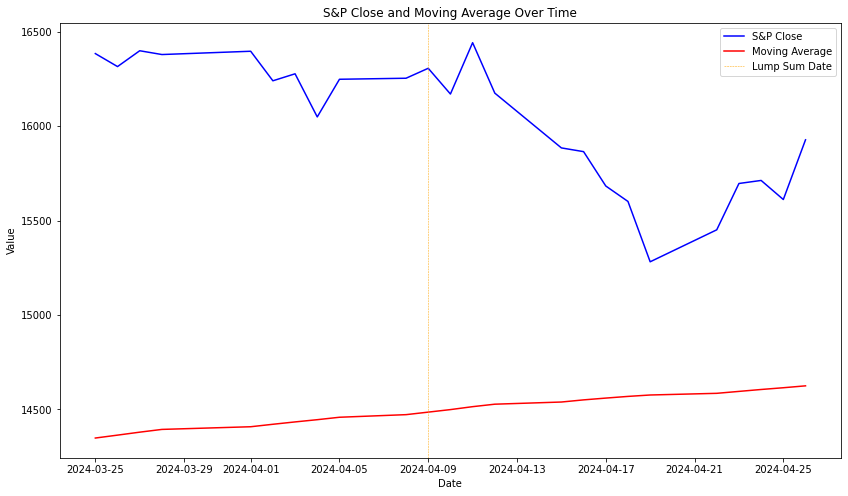

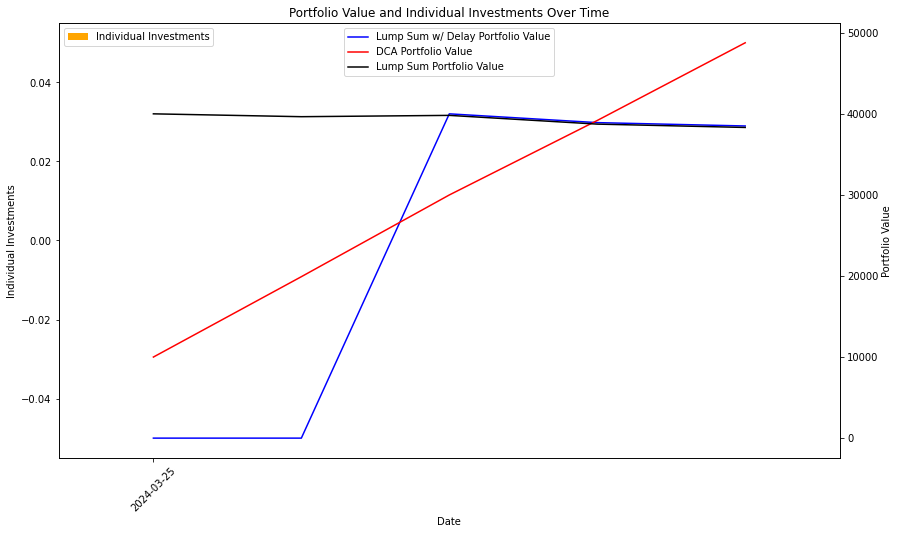

Initial Date : 1999-07-19
Start Date   : 2000-07-03 00:00:00
Lump Sum Date: 2000-07-18
End Date     : 2001-07-03


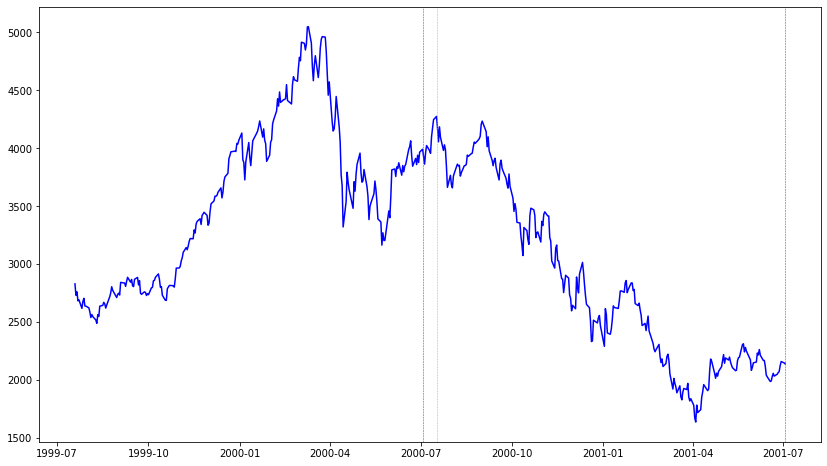

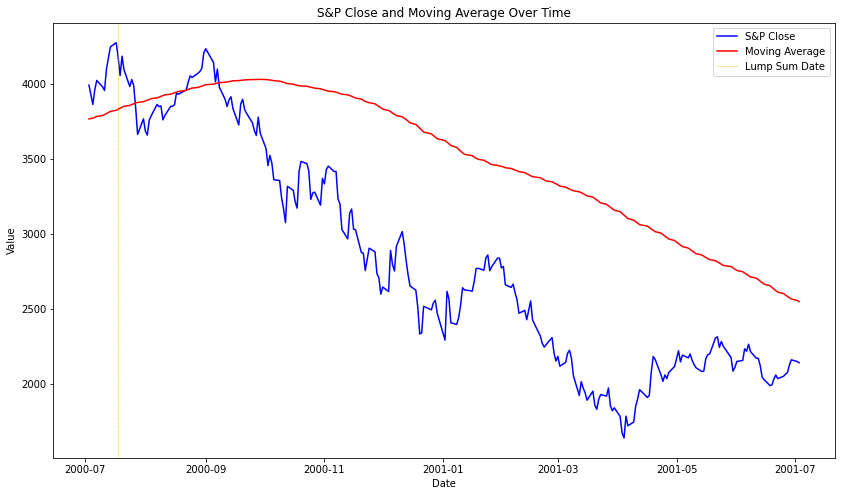

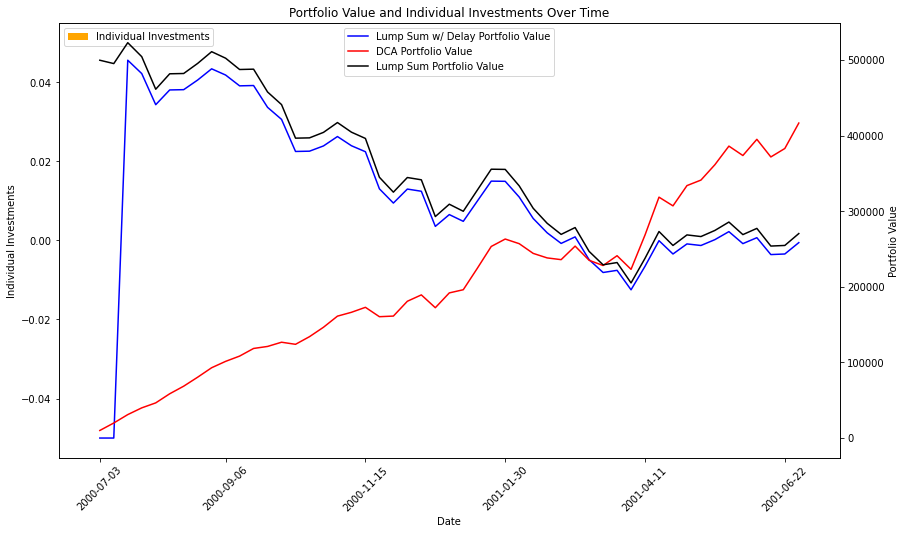

Initial Date : 2023-03-21
Start Date   : 2024-03-06 00:00:00
Lump Sum Date: 2024-03-20
End Date     : 2025-03-06


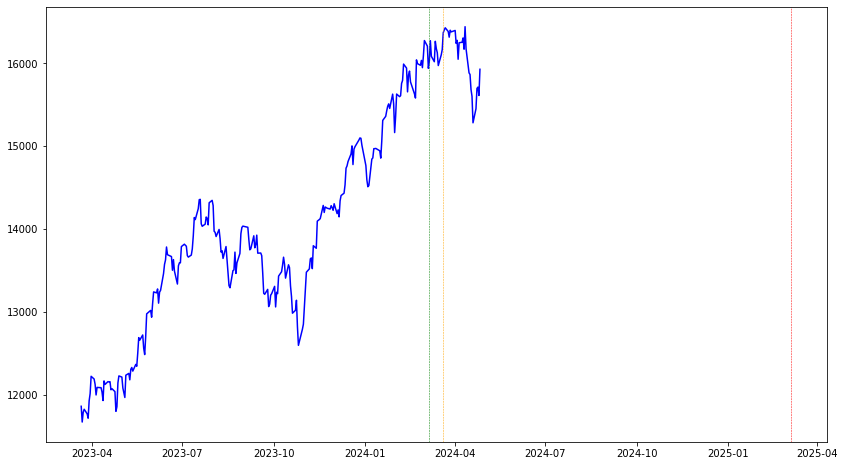

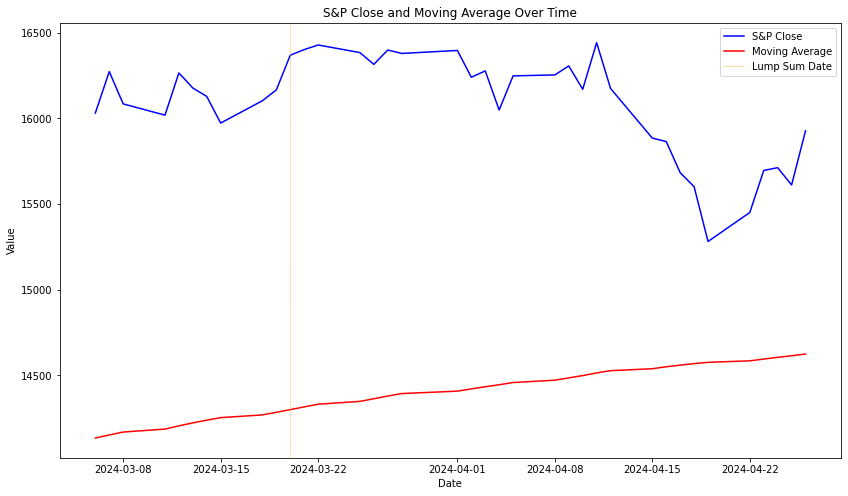

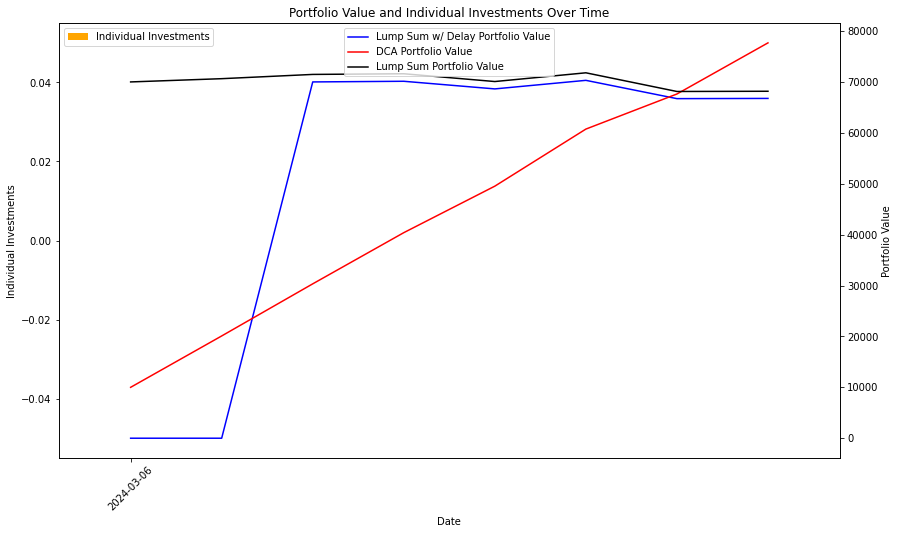

Initial Date : 1999-06-28
Start Date   : 2000-06-13 00:00:00
Lump Sum Date: 2000-06-27
End Date     : 2001-06-13


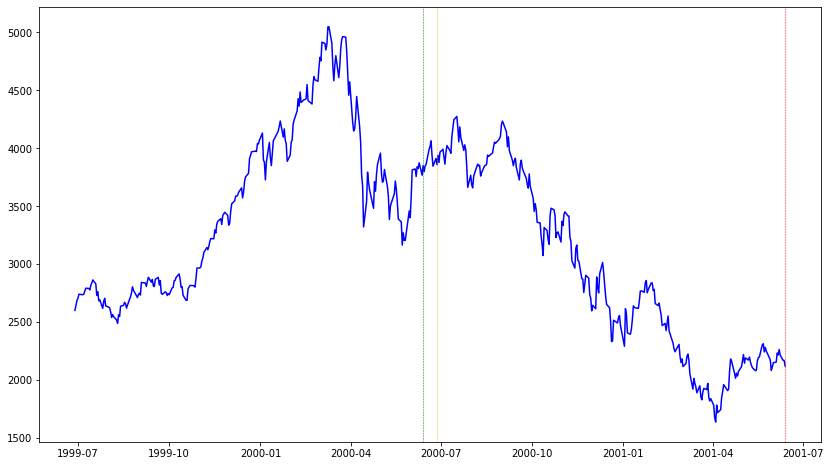

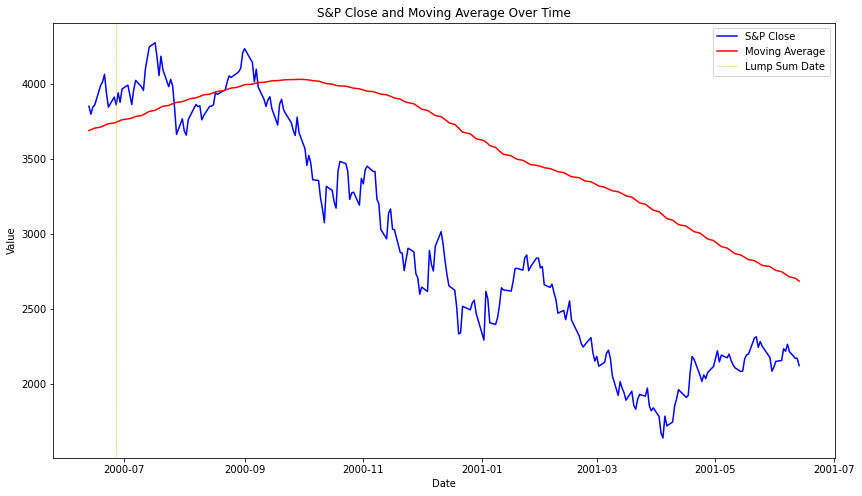

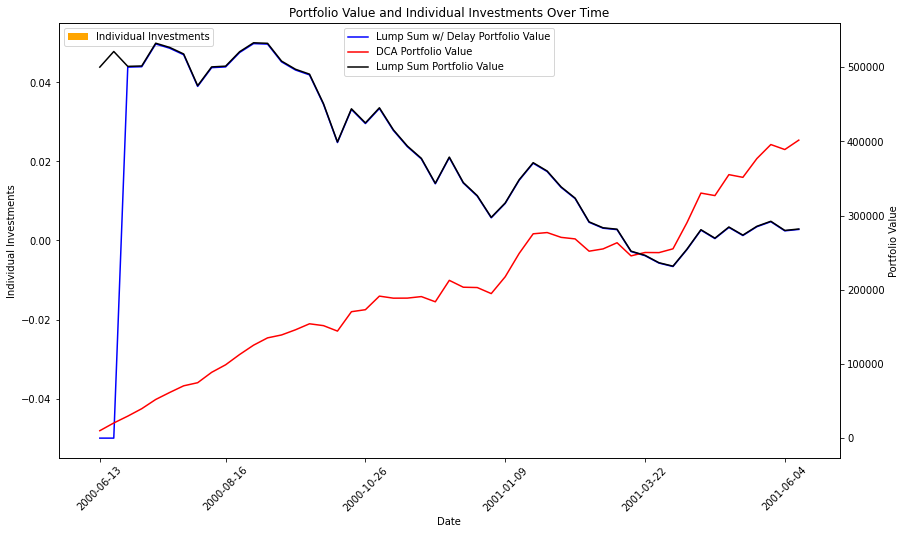

Initial Date : 2001-01-23
Start Date   : 2001-08-09 00:00:00
Lump Sum Date: 2002-01-23
End Date     : 2002-08-09


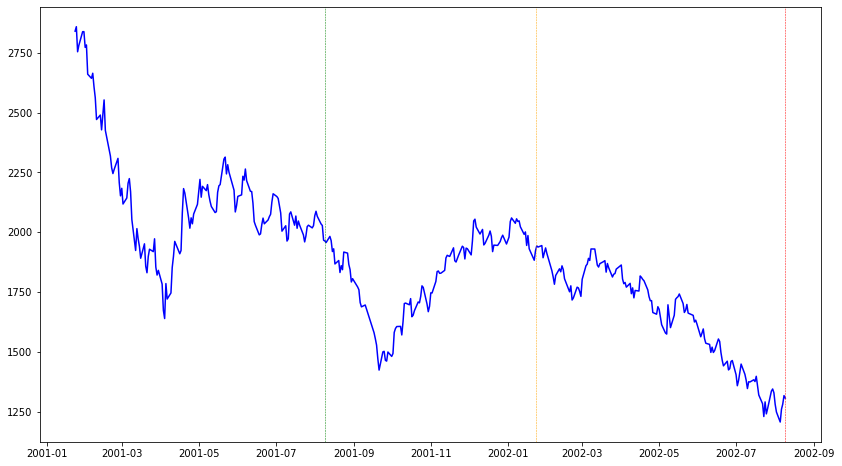

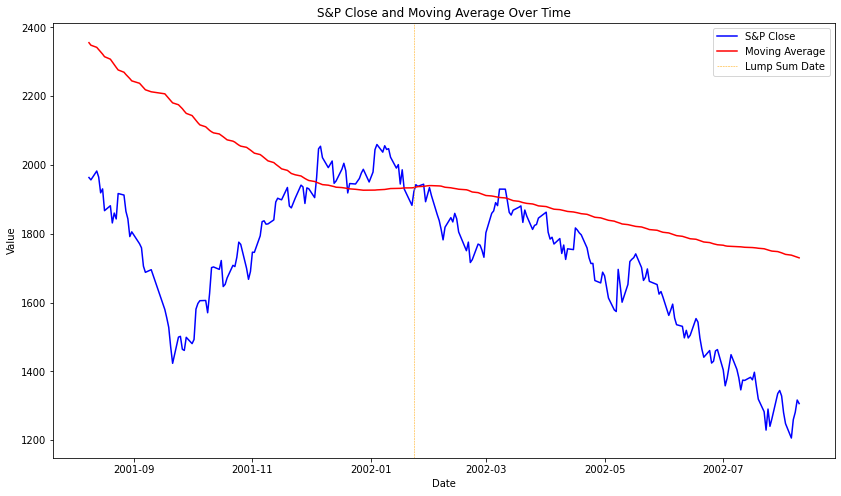

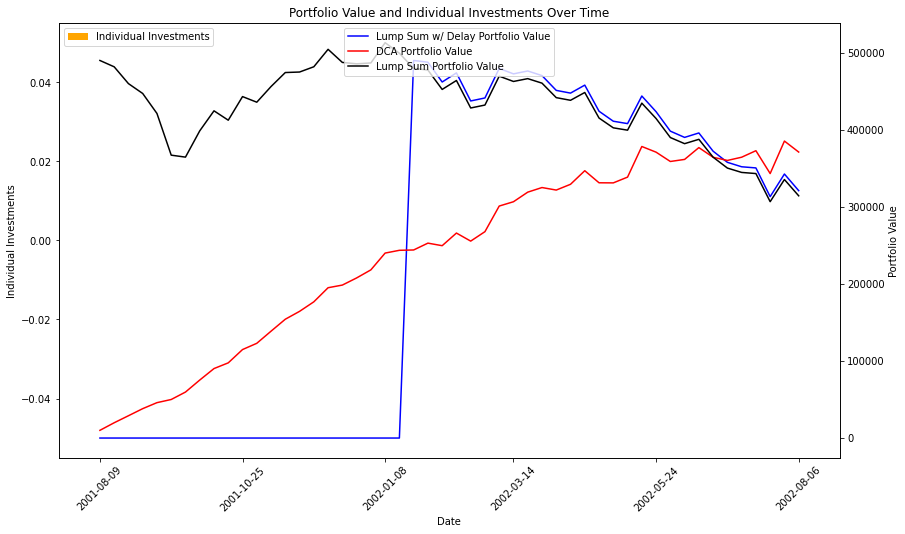

Initial Date : 2006-11-28
Start Date   : 2007-11-13 00:00:00
Lump Sum Date: 2007-11-28
End Date     : 2008-11-13


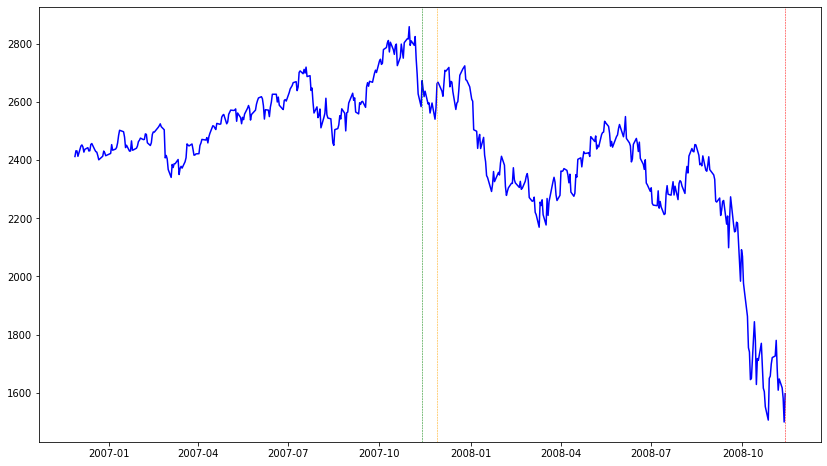

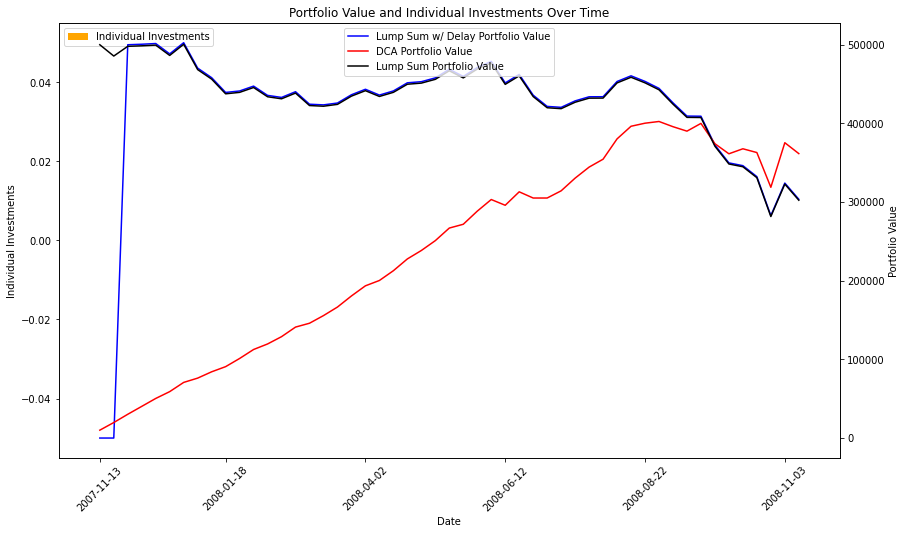

Initial Date : 2001-01-17
Start Date   : 2001-07-09 00:00:00
Lump Sum Date: 2002-01-17
End Date     : 2002-07-09


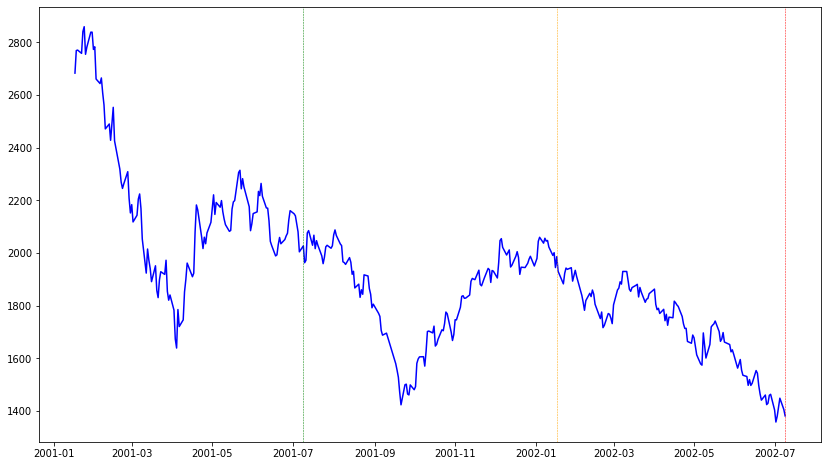

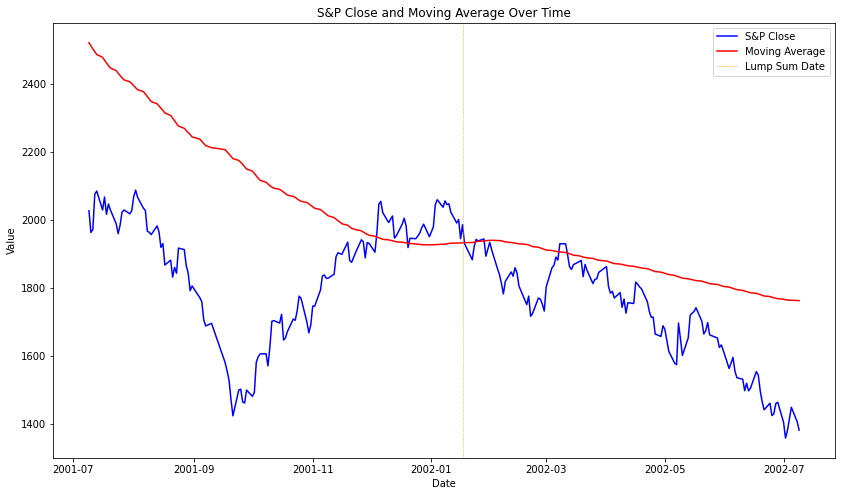

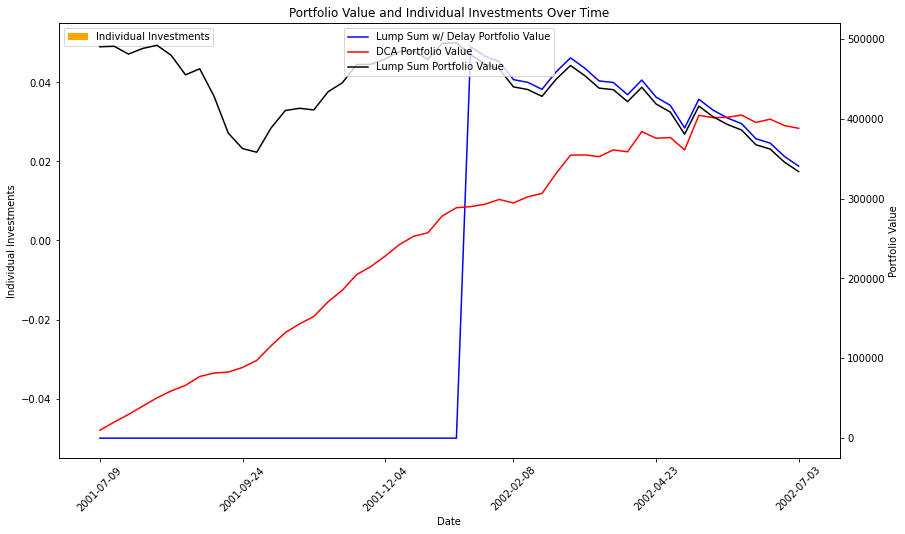

Initial Date : 2007-01-02
Start Date   : 2007-12-17 00:00:00
Lump Sum Date: 2008-01-02
End Date     : 2008-12-17


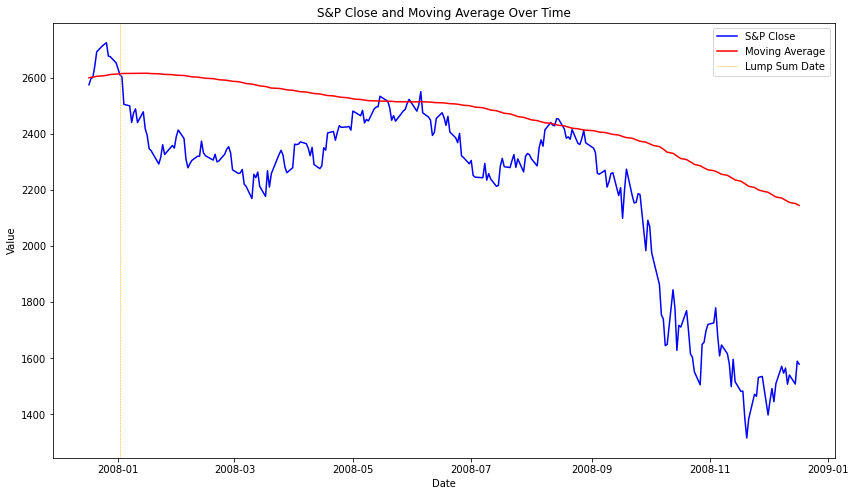

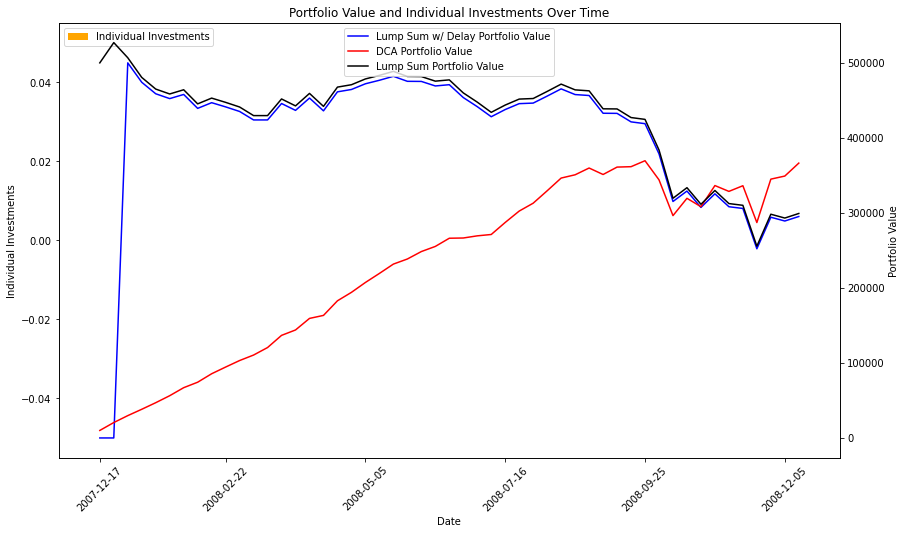

Initial Date : 2020-08-31
Start Date   : 2021-08-17 00:00:00
Lump Sum Date: 2021-08-31
End Date     : 2022-08-17


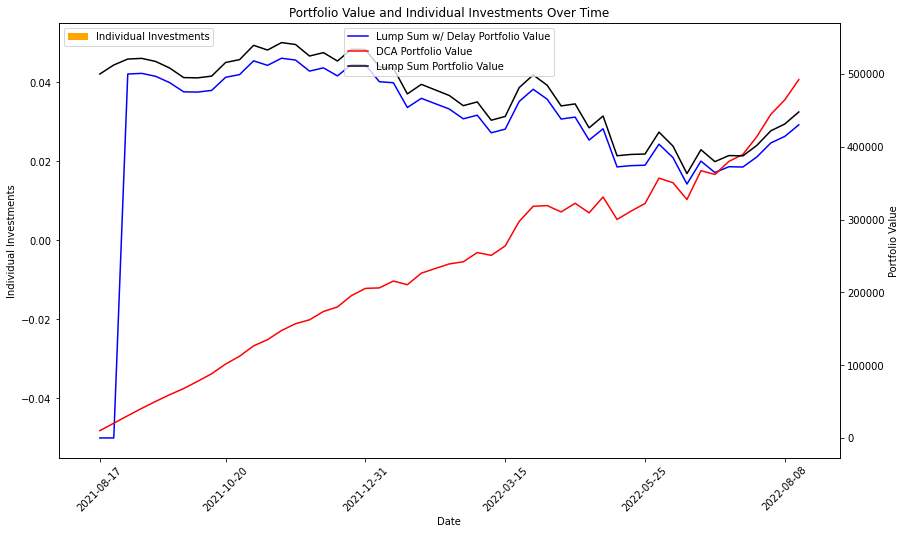

Initial Date : 2001-01-18
Start Date   : 2001-11-20 00:00:00
Lump Sum Date: 2002-01-18
End Date     : 2002-11-20


Initial Date : 1999-06-23
Start Date   : 2000-06-08 00:00:00
Lump Sum Date: 2000-06-22
End Date     : 2001-06-08


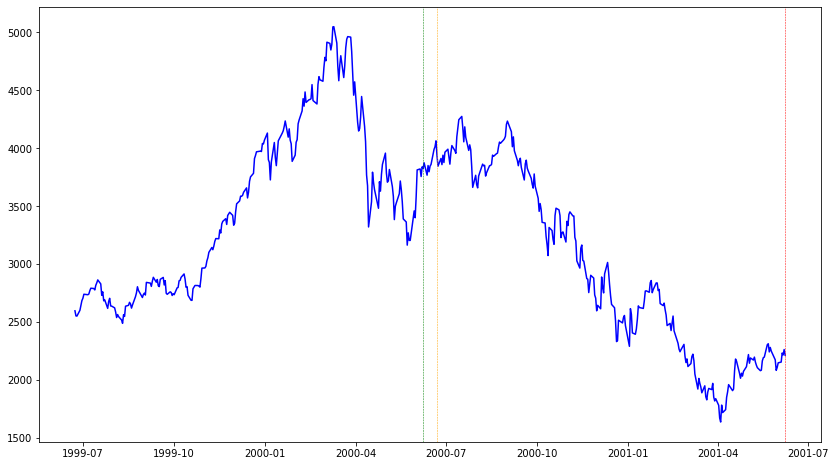

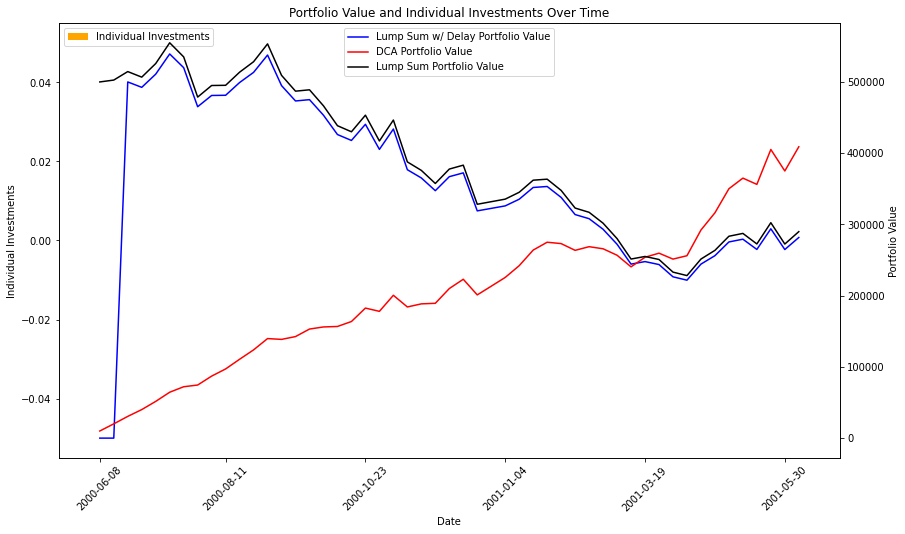

Initial Date : 2001-01-18
Start Date   : 2001-06-25 00:00:00
Lump Sum Date: 2002-01-18
End Date     : 2002-06-25


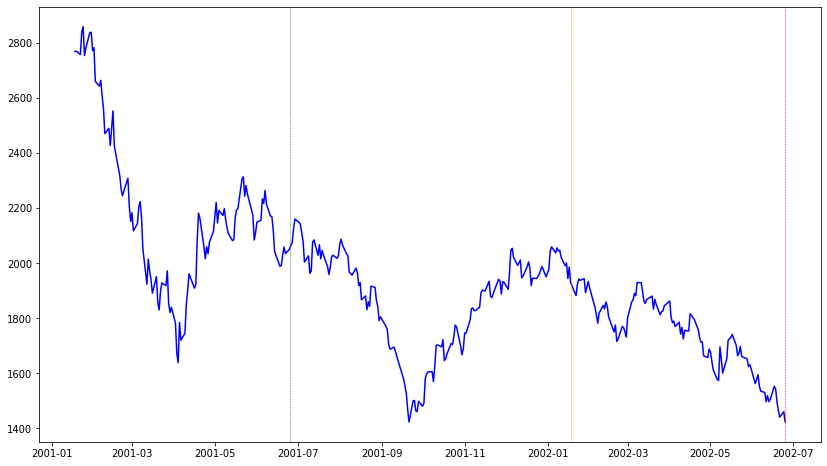

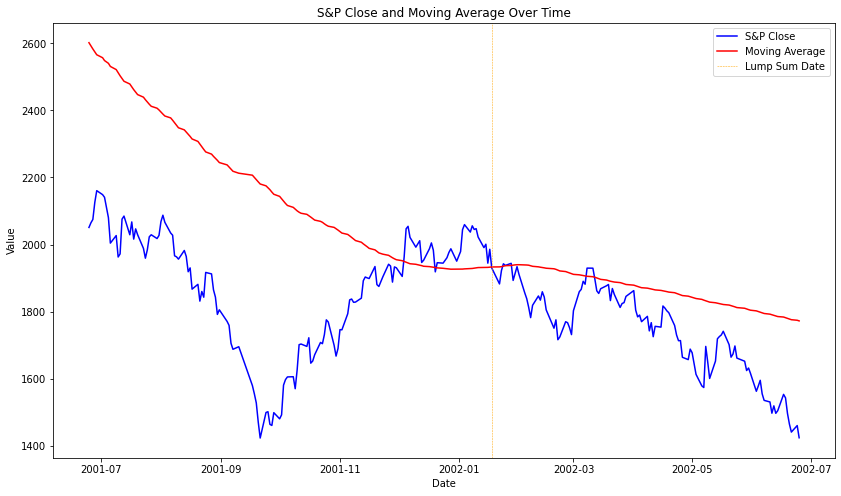

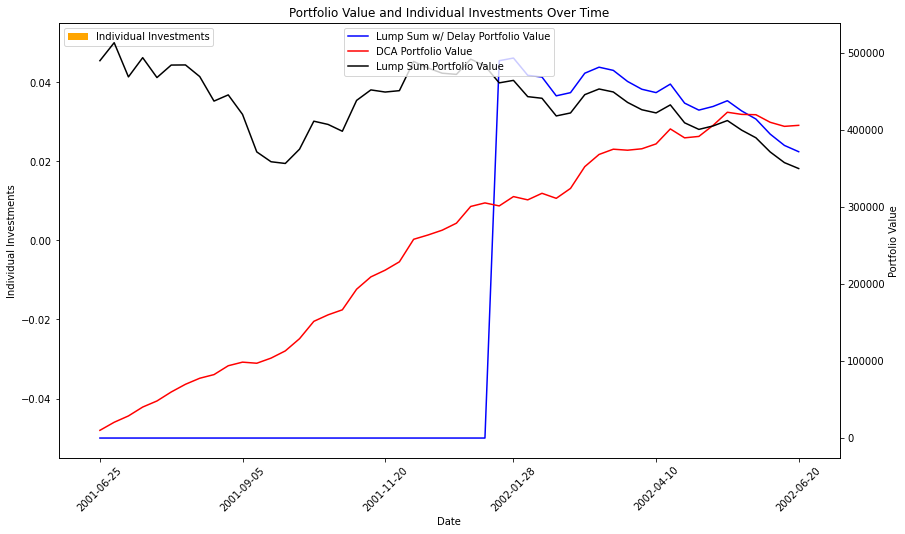

Initial Date : 2001-01-25
Start Date   : 2002-01-10 00:00:00
Lump Sum Date: 2002-01-25
End Date     : 2003-01-10


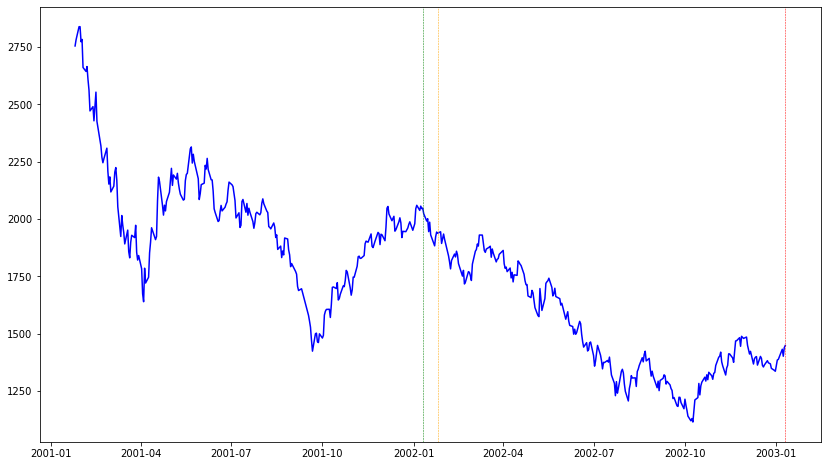

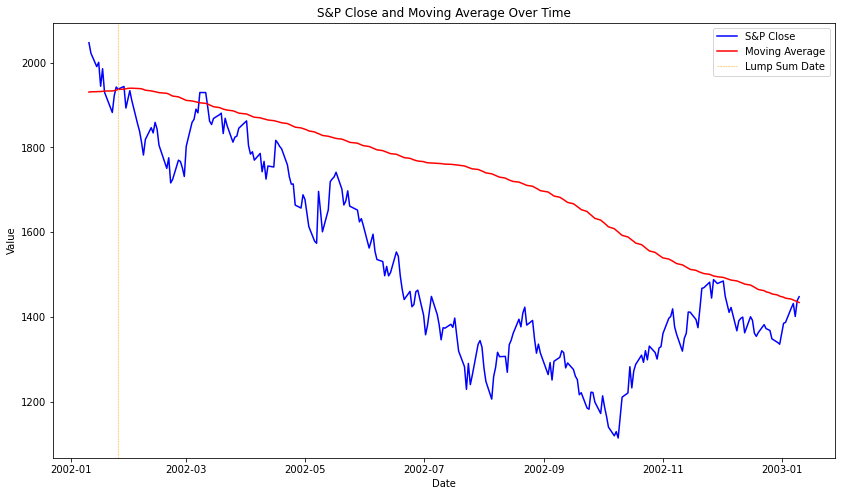

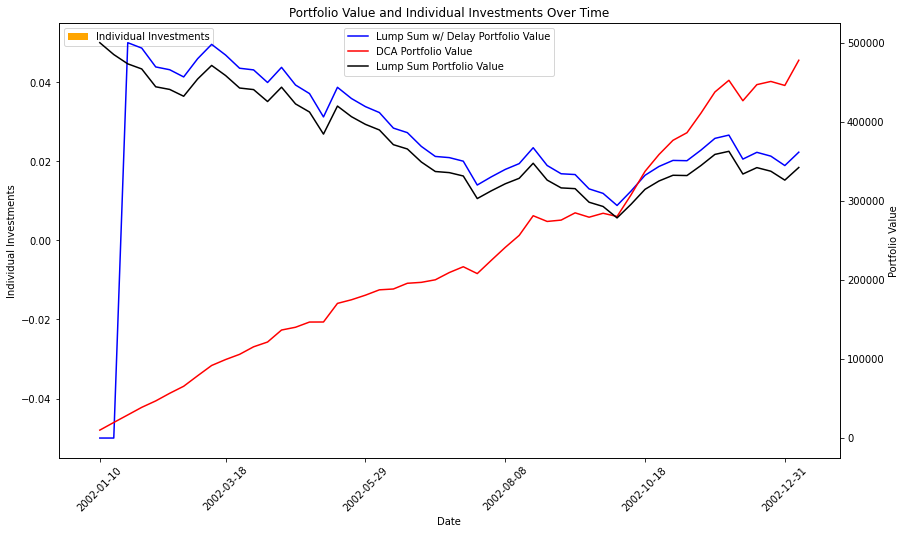

Initial Date : 2007-01-11
Start Date   : 2007-12-27 00:00:00
Lump Sum Date: 2008-01-11
End Date     : 2008-12-27


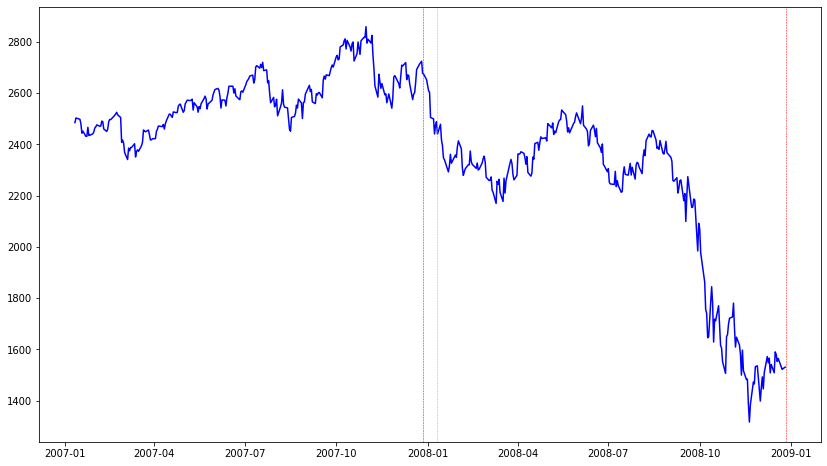

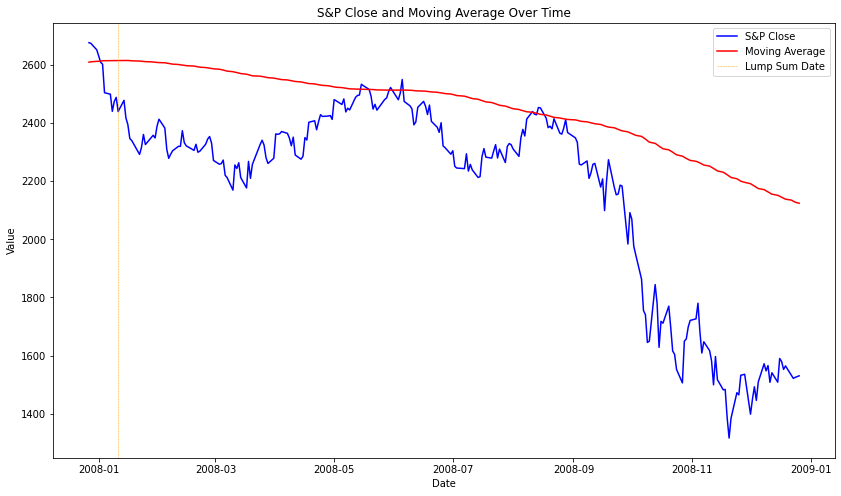

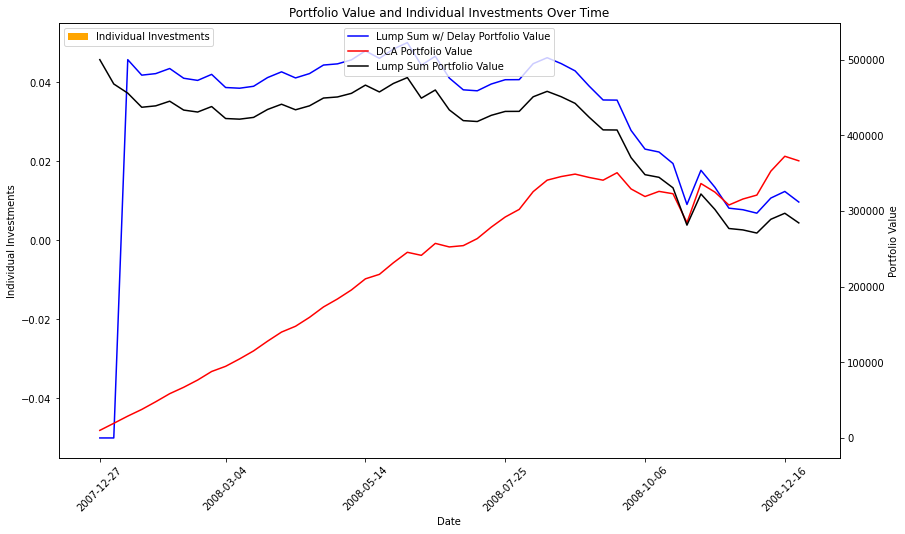

Initial Date : 2001-01-16
Start Date   : 2001-08-17 00:00:00
Lump Sum Date: 2002-01-16
End Date     : 2002-08-17


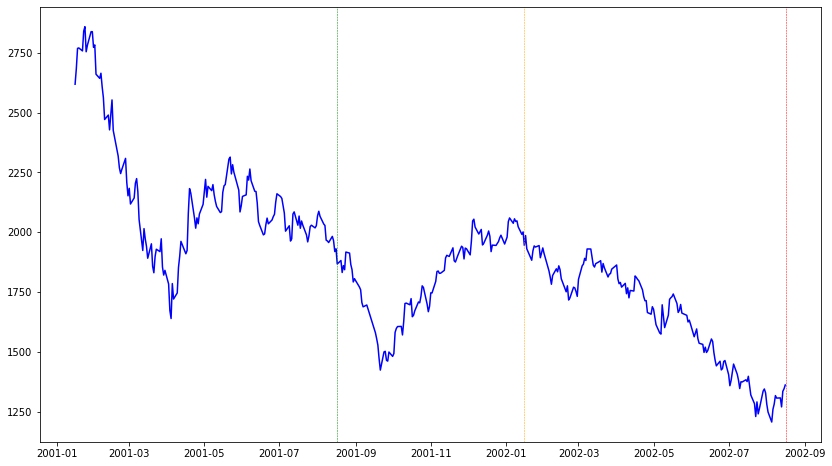

Initial Date : 2008-07-23
Start Date   : 2008-07-25 00:00:00
Lump Sum Date: 2009-07-23
End Date     : 2009-07-25


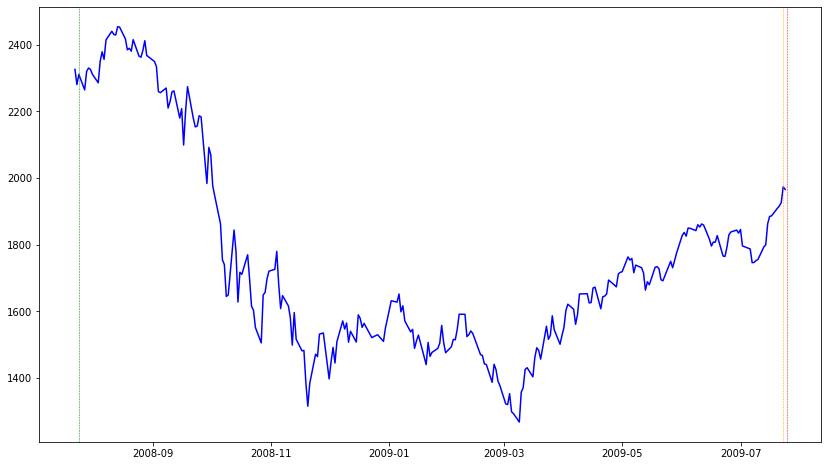

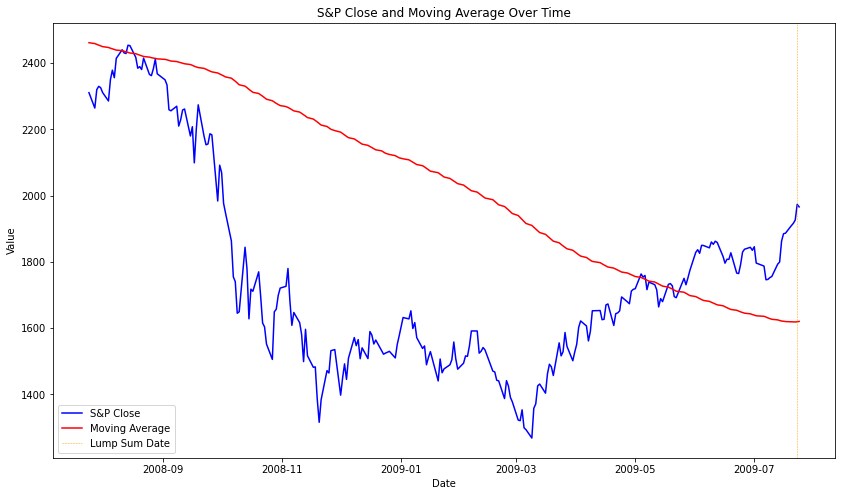

Initial Date : 1999-02-22
Start Date   : 2000-02-07 00:00:00
Lump Sum Date: 2000-02-22
End Date     : 2001-02-07


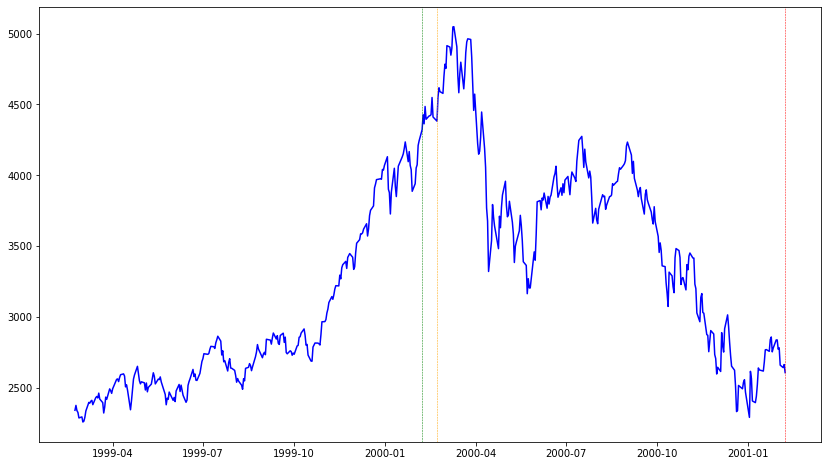

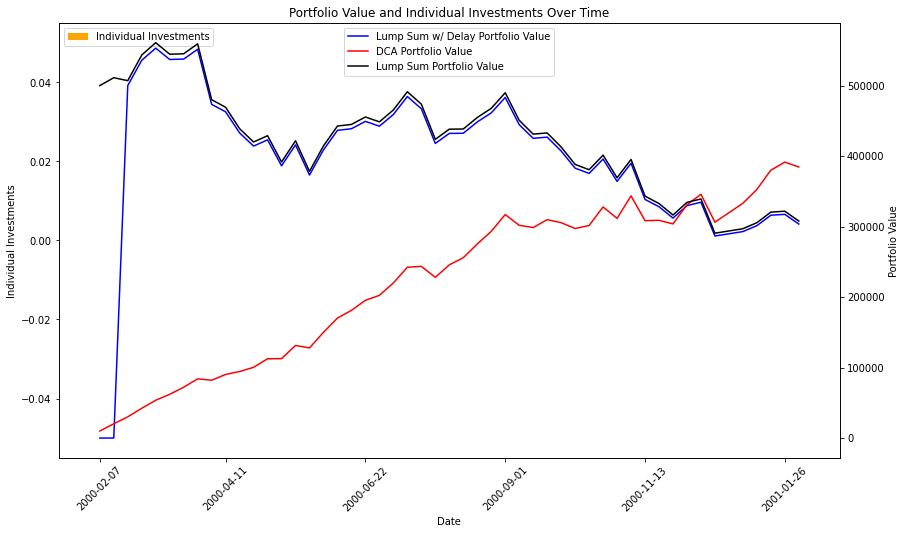

Initial Date : 2023-04-12
Start Date   : 2024-03-27 00:00:00
Lump Sum Date: 2024-04-11
End Date     : 2025-03-27


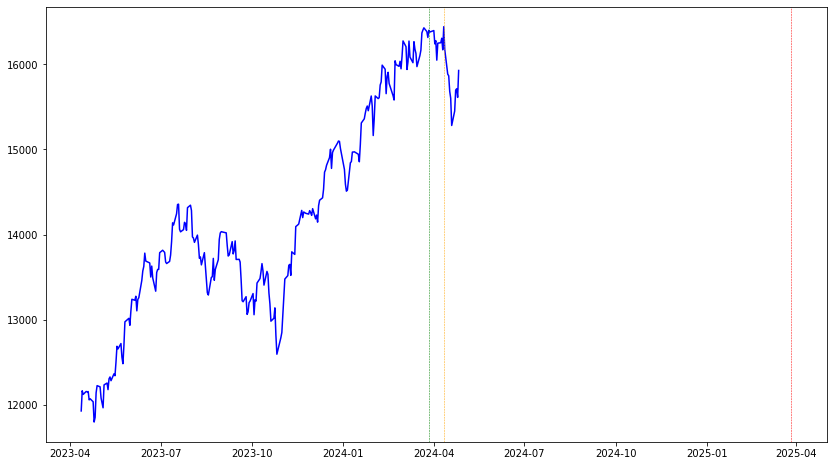

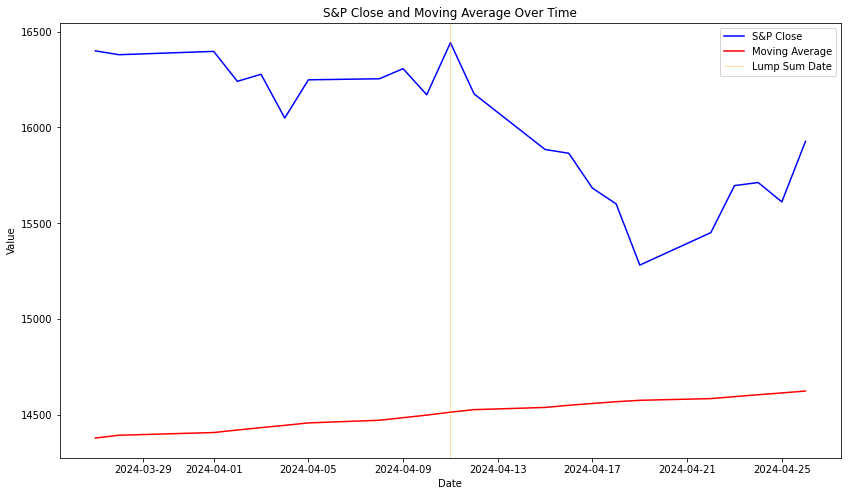

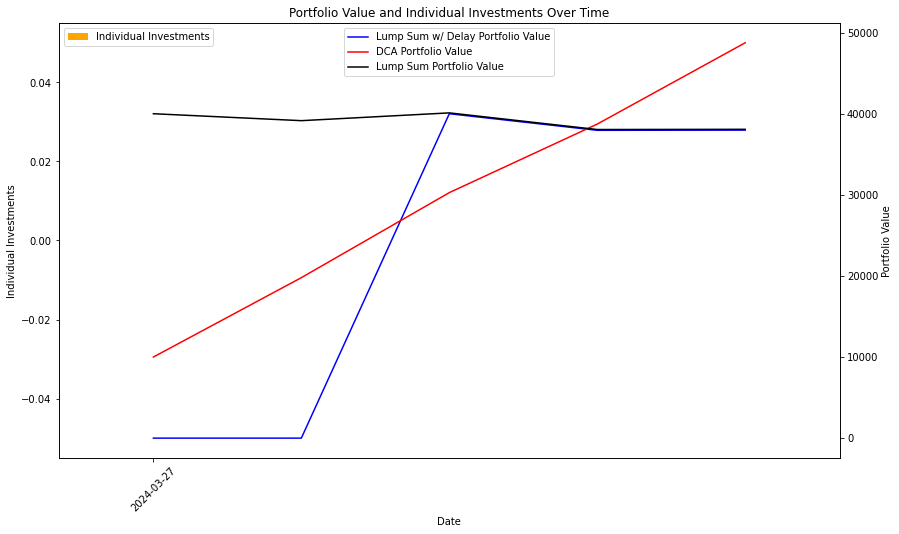

Initial Date : 2020-12-15
Start Date   : 2021-12-01 00:00:00
Lump Sum Date: 2021-12-15
End Date     : 2022-12-01


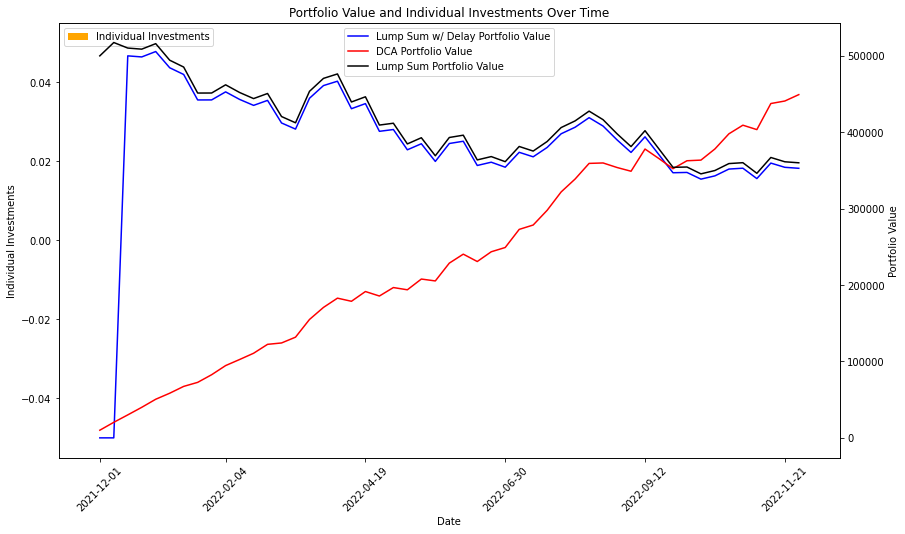

Initial Date : 1999-09-20
Start Date   : 2000-09-05 00:00:00
Lump Sum Date: 2000-09-19
End Date     : 2001-09-05


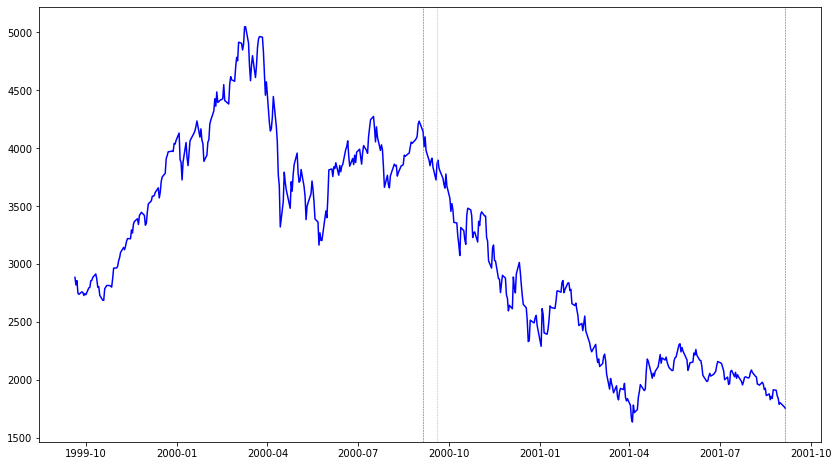

Initial Date : 1999-08-23
Start Date   : 2000-08-08 00:00:00
Lump Sum Date: 2000-08-22
End Date     : 2001-08-08


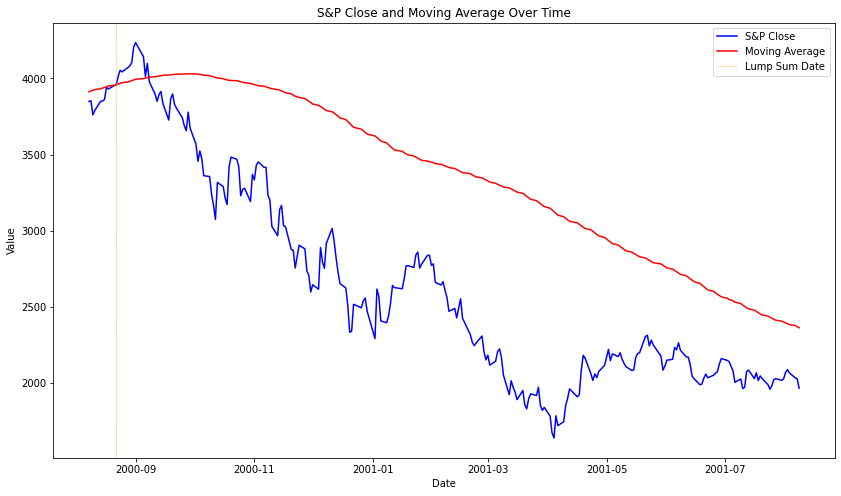

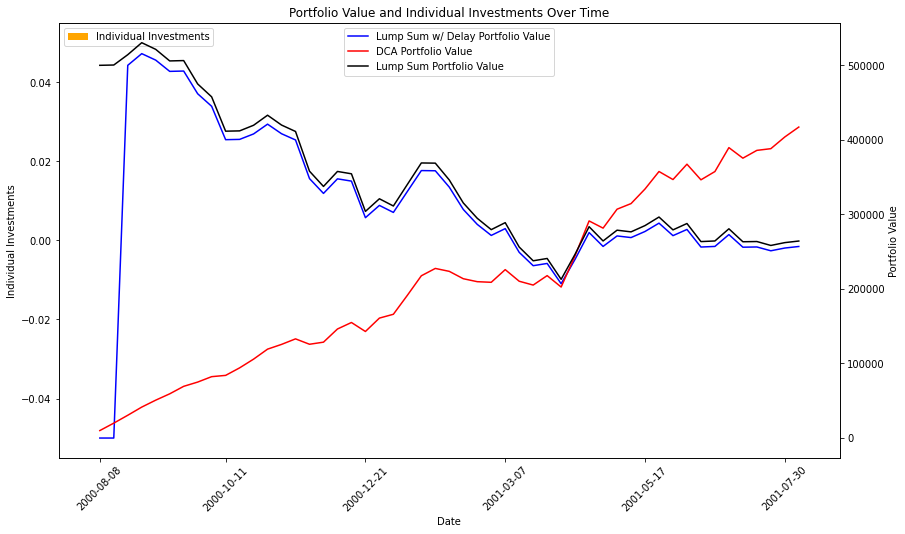

Initial Date : 1999-06-27
Start Date   : 2000-06-12 00:00:00
Lump Sum Date: 2000-06-26
End Date     : 2001-06-12


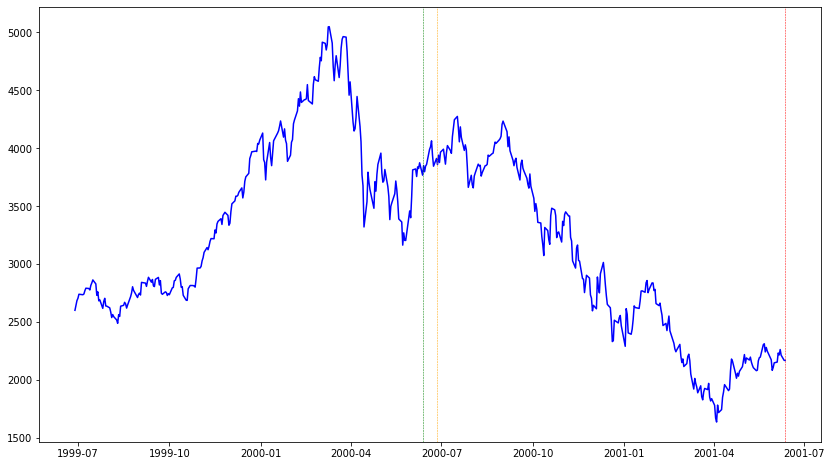

Initial Date : 2021-03-31
Start Date   : 2022-03-17 00:00:00
Lump Sum Date: 2022-03-31
End Date     : 2023-03-17


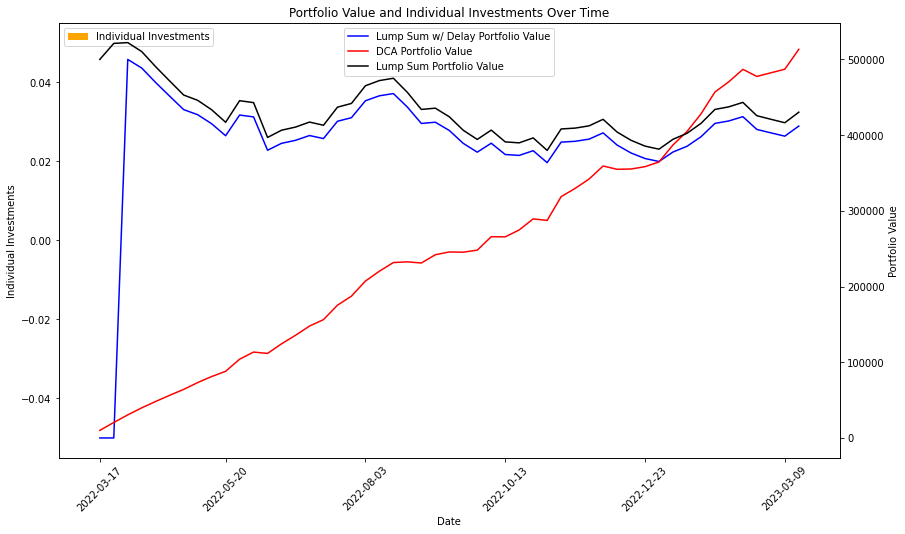

Initial Date : 2001-01-23
Start Date   : 2001-12-07 00:00:00
Lump Sum Date: 2002-01-23
End Date     : 2002-12-07


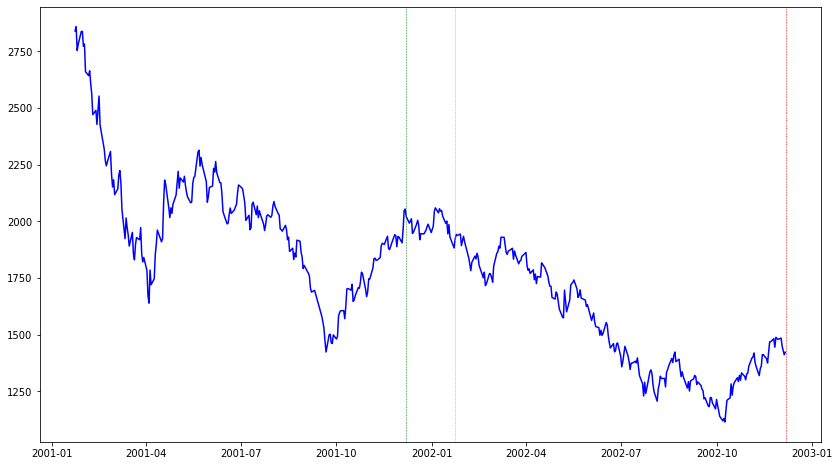

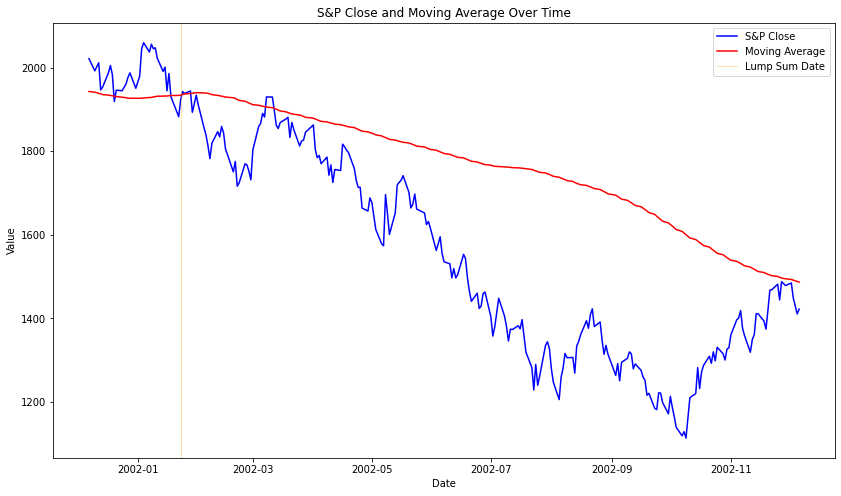

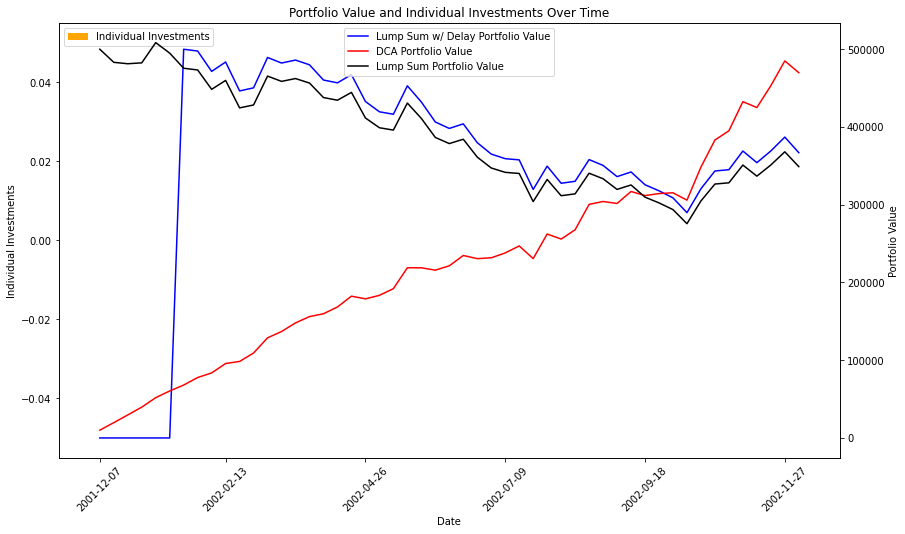

Initial Date : 1999-06-15
Start Date   : 2000-05-31 00:00:00
Lump Sum Date: 2000-06-14
End Date     : 2001-05-31


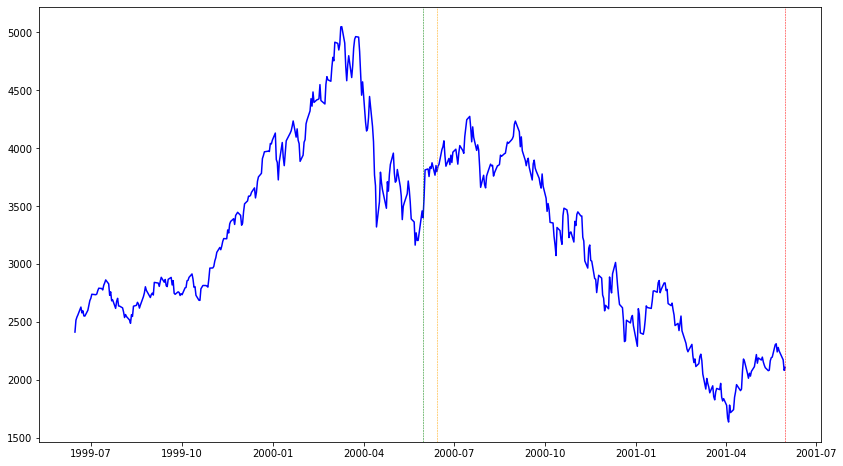

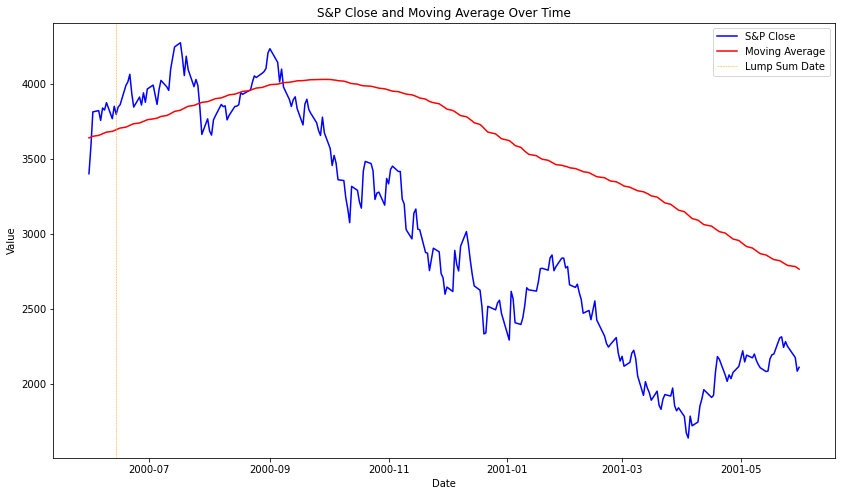

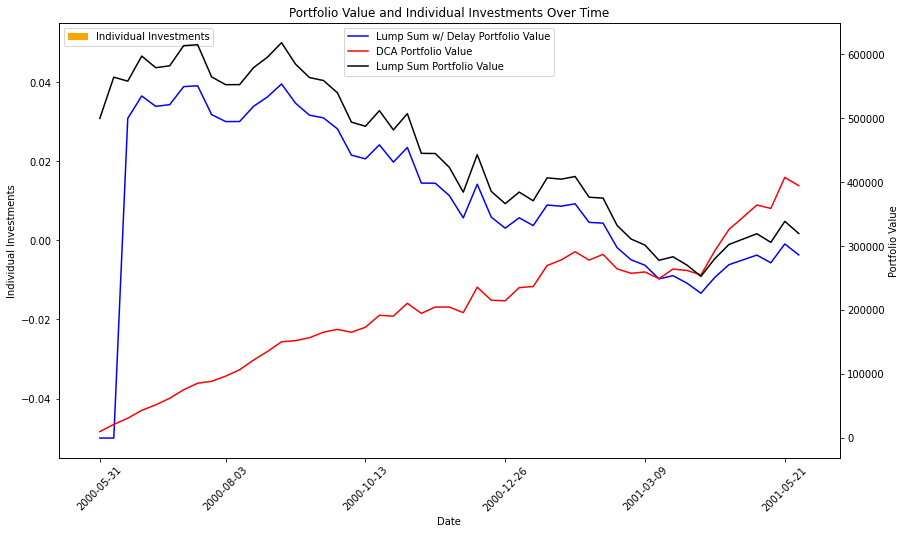

Initial Date : 2001-01-24
Start Date   : 2002-01-09 00:00:00
Lump Sum Date: 2002-01-24
End Date     : 2003-01-09


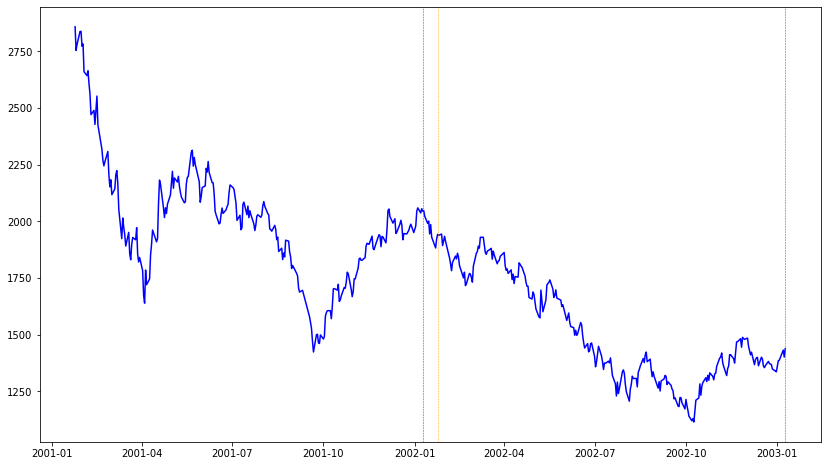

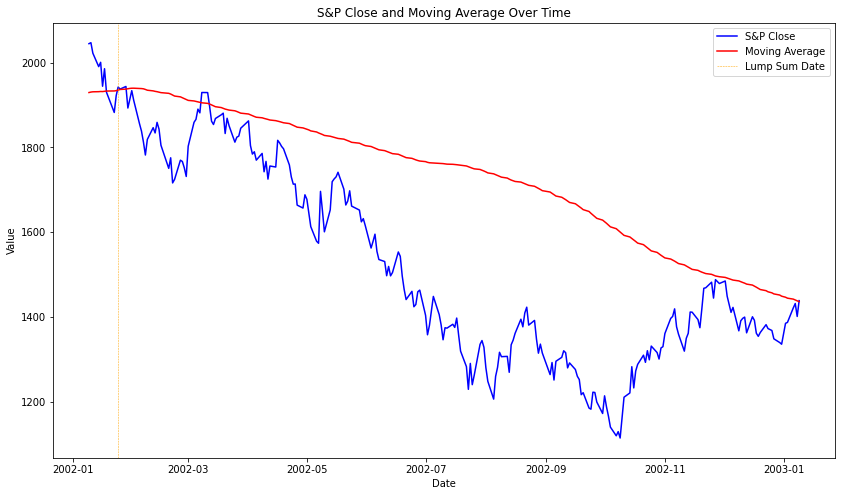

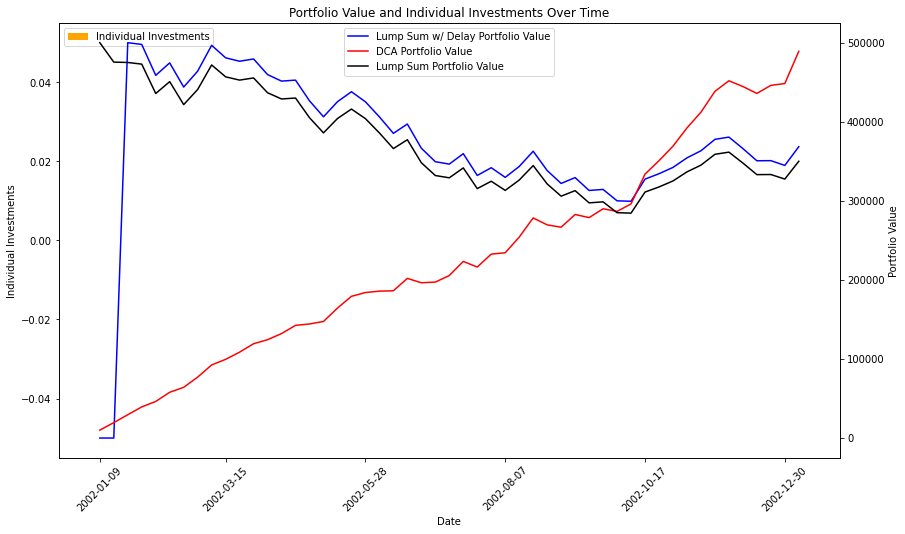

Initial Date : 2021-02-14
Start Date   : 2022-01-31 00:00:00
Lump Sum Date: 2022-02-14
End Date     : 2023-01-31


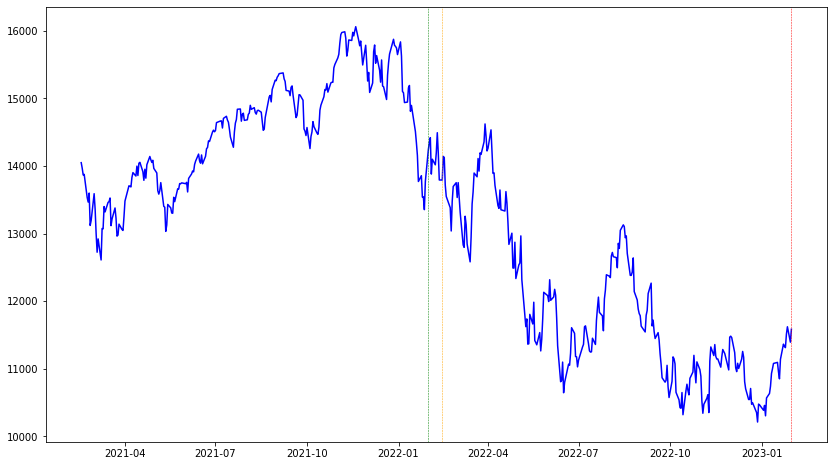

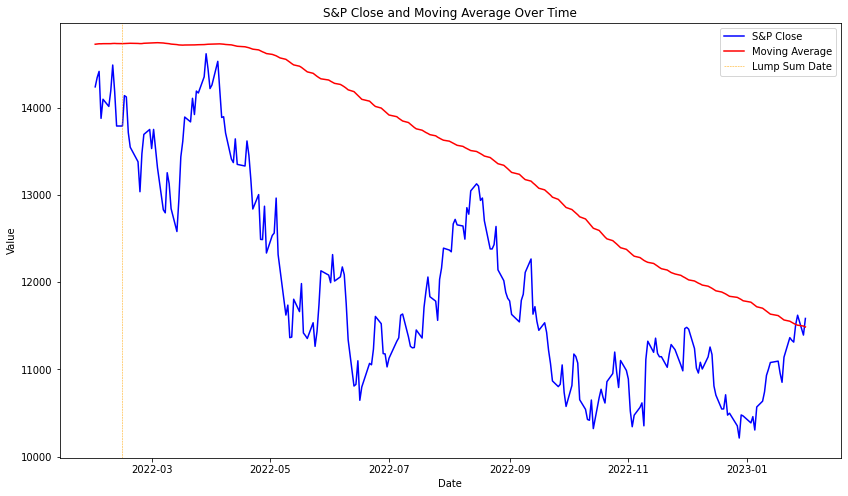

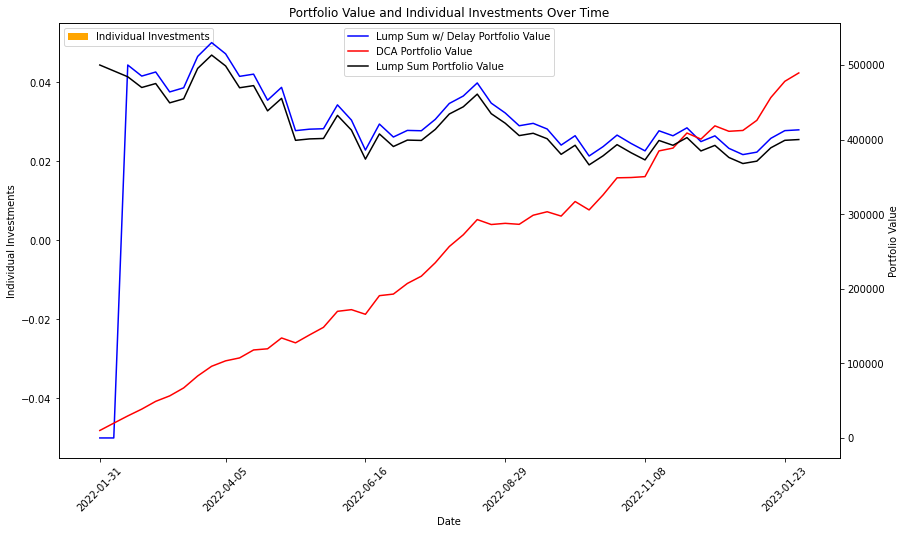

Initial Date : 2006-11-27
Start Date   : 2007-11-12 00:00:00
Lump Sum Date: 2007-11-27
End Date     : 2008-11-12


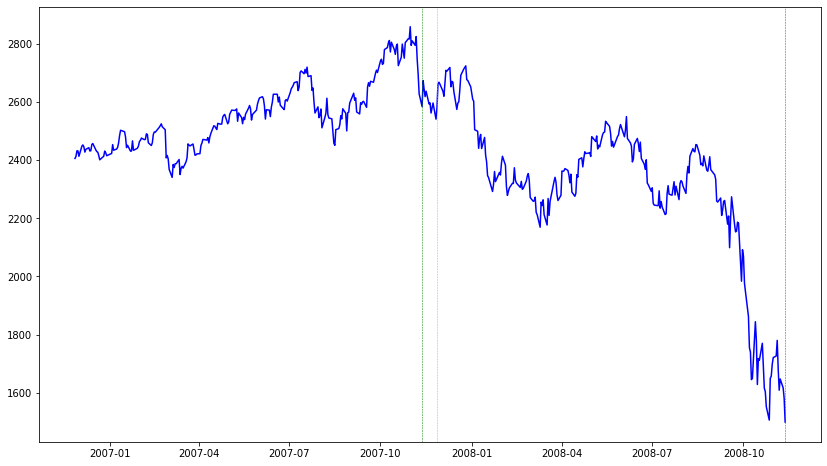

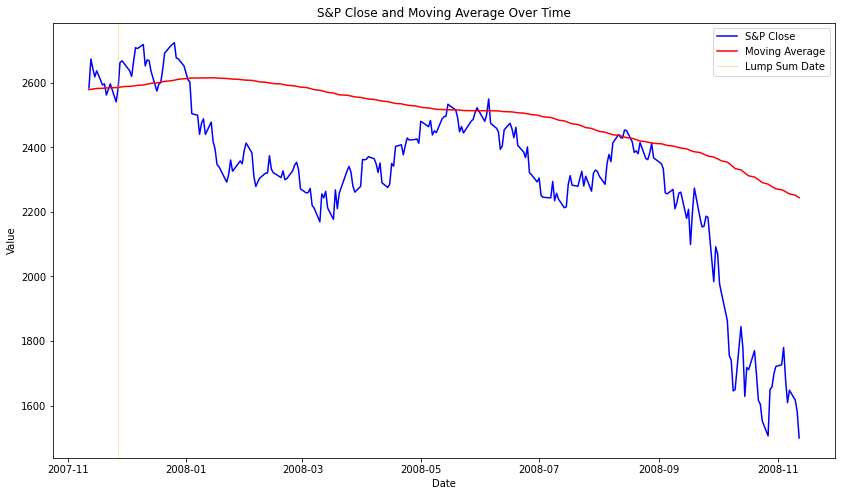

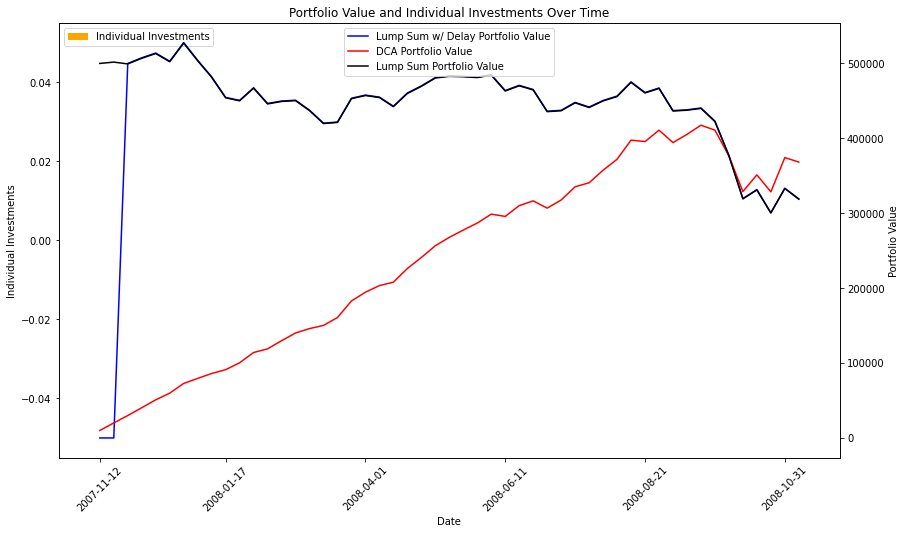

Initial Date : 1999-02-28
Start Date   : 2000-02-11 00:00:00
Lump Sum Date: 2000-02-28
End Date     : 2001-02-11


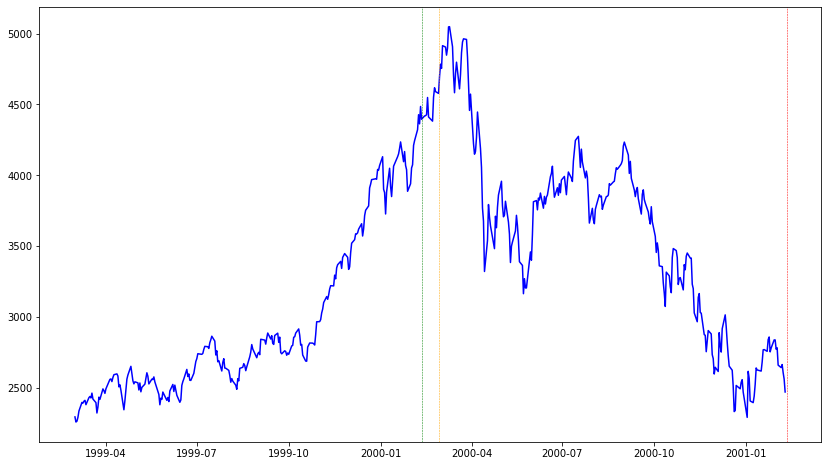

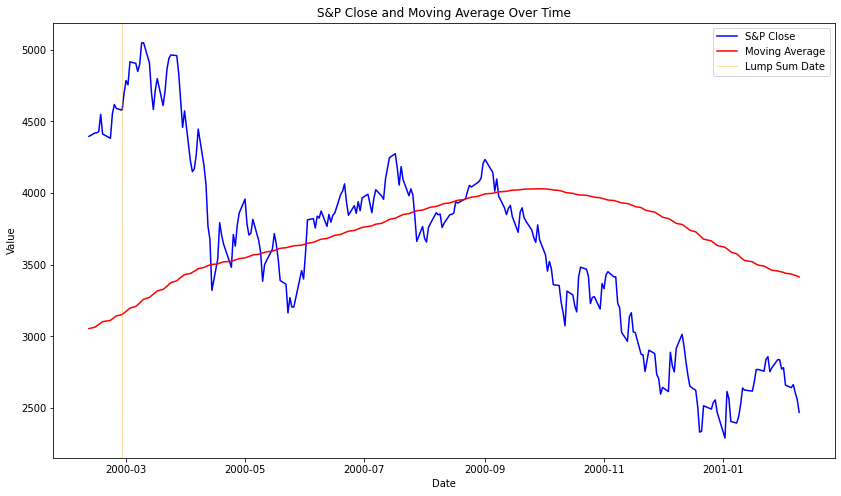

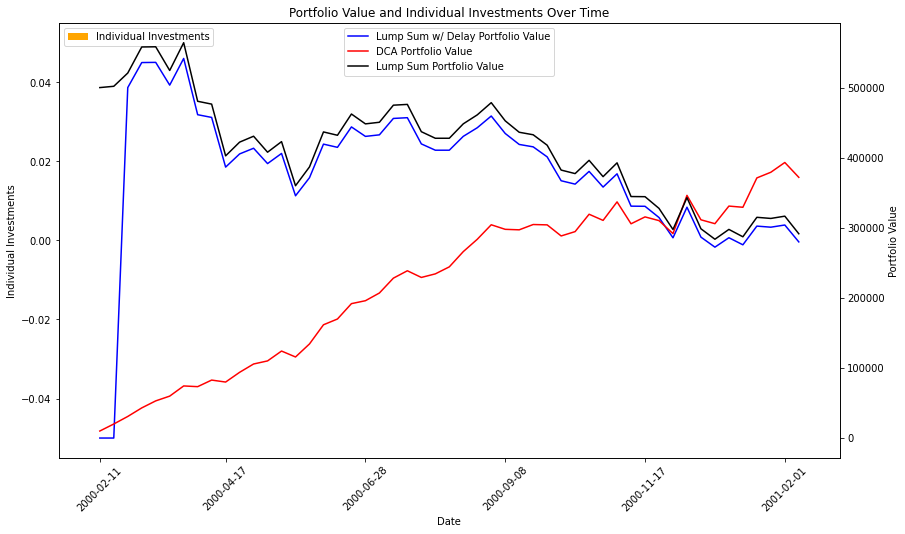

Initial Date : 2023-04-23
Start Date   : 2024-04-08 00:00:00
Lump Sum Date: 2024-04-22
End Date     : 2025-04-08


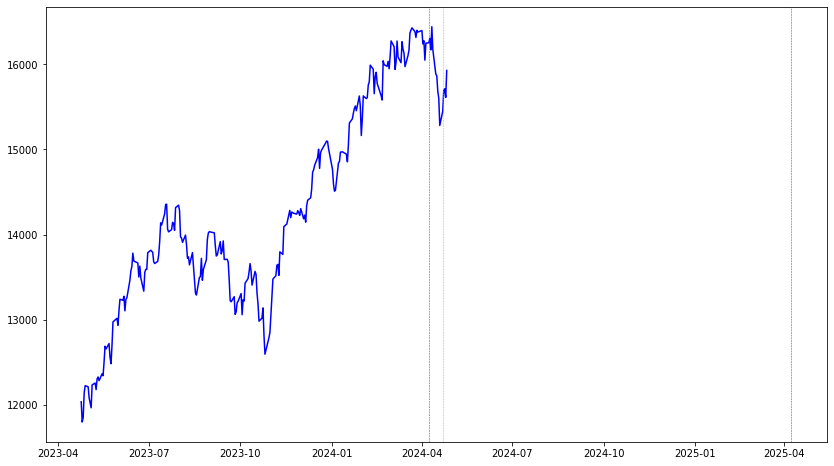

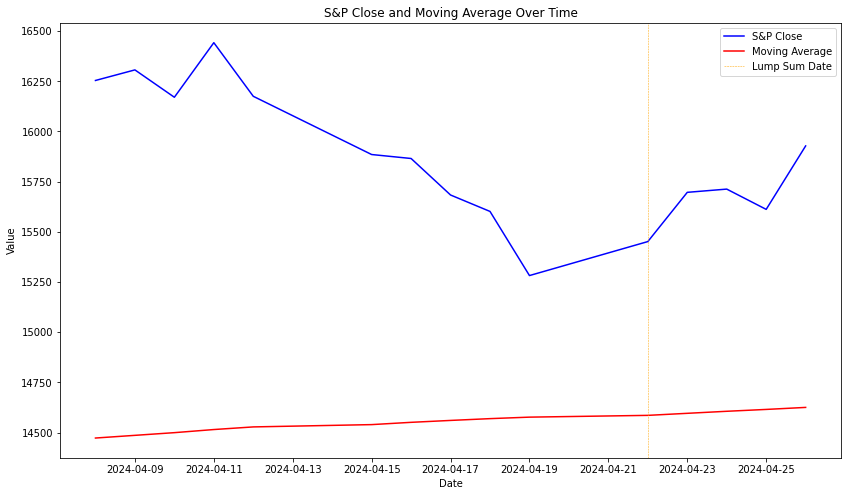

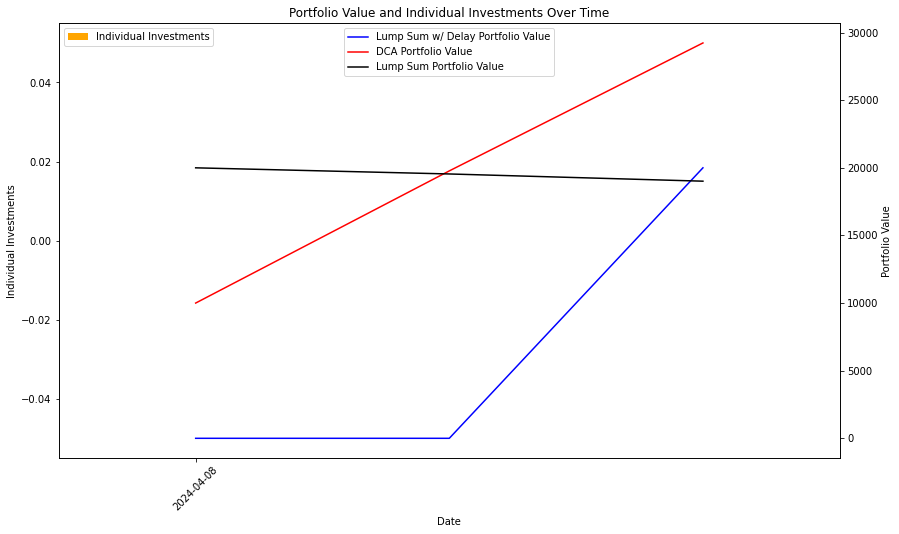

Initial Date : 2020-11-22
Start Date   : 2021-11-08 00:00:00
Lump Sum Date: 2021-11-22
End Date     : 2022-11-08


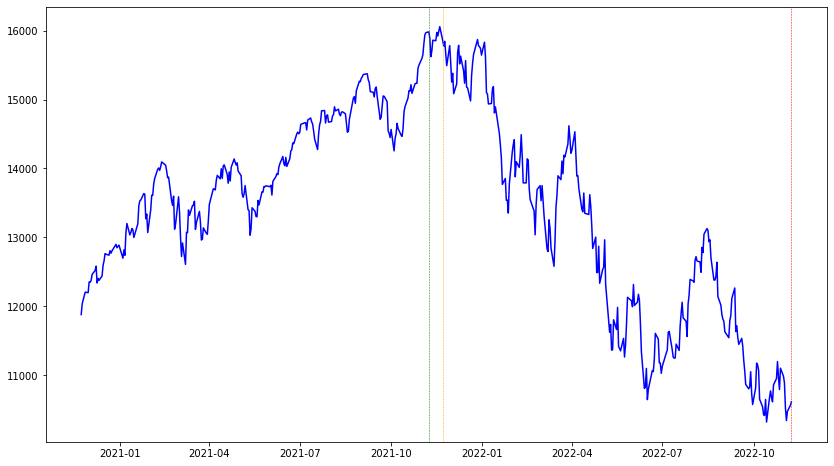

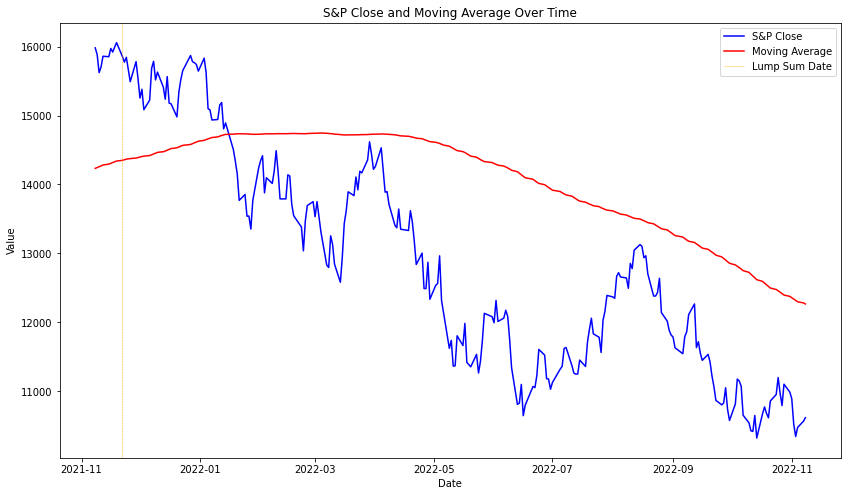

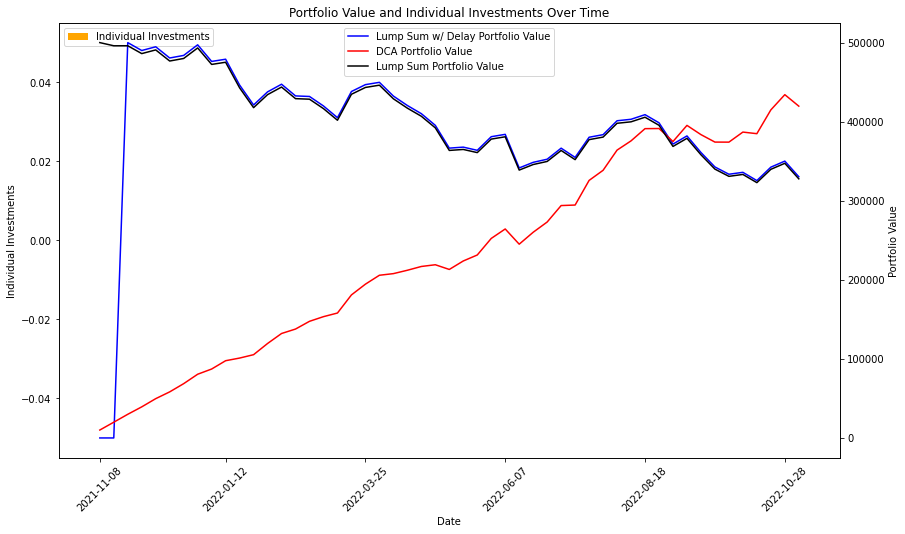

Initial Date : 2001-01-22
Start Date   : 2001-08-01 00:00:00
Lump Sum Date: 2002-01-22
End Date     : 2002-08-01


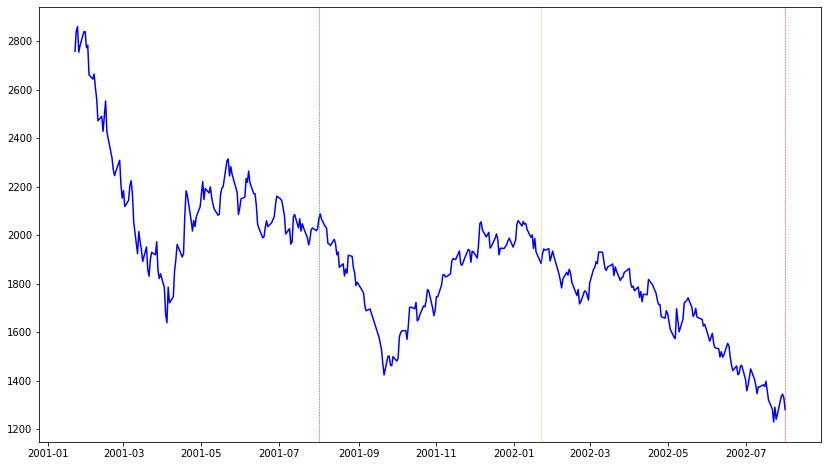

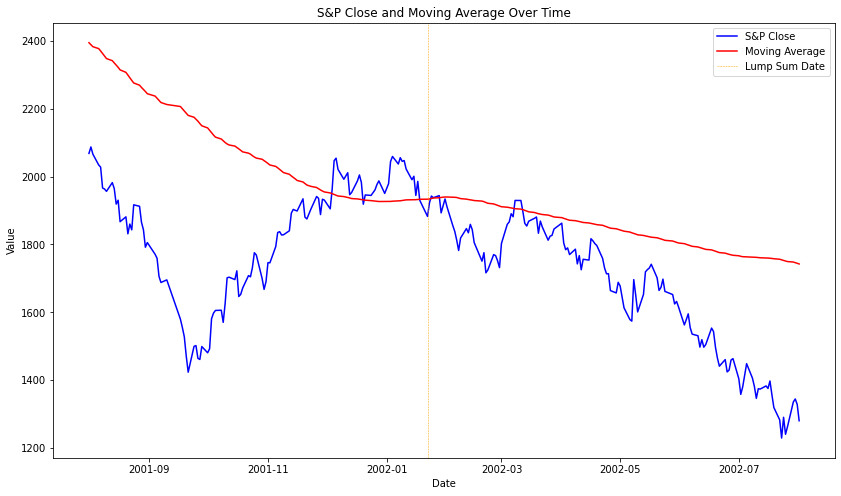

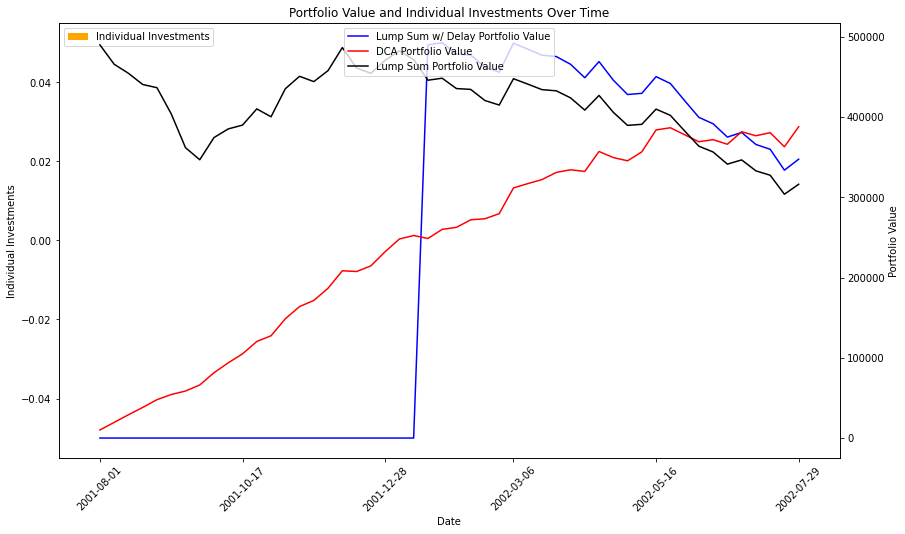

Initial Date : 1999-05-26
Start Date   : 2000-05-11 00:00:00
Lump Sum Date: 2000-05-25
End Date     : 2001-05-11


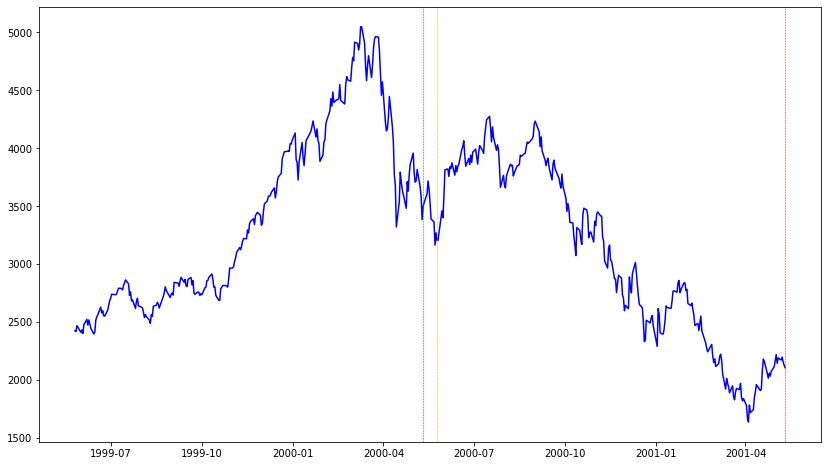

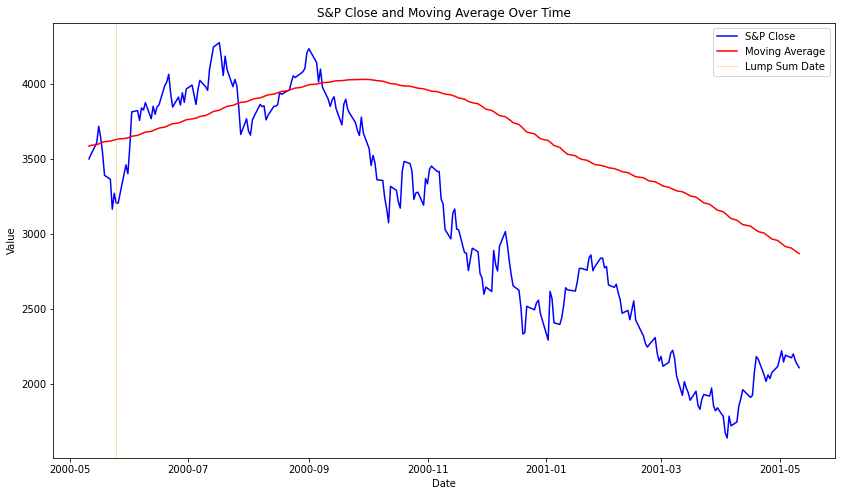

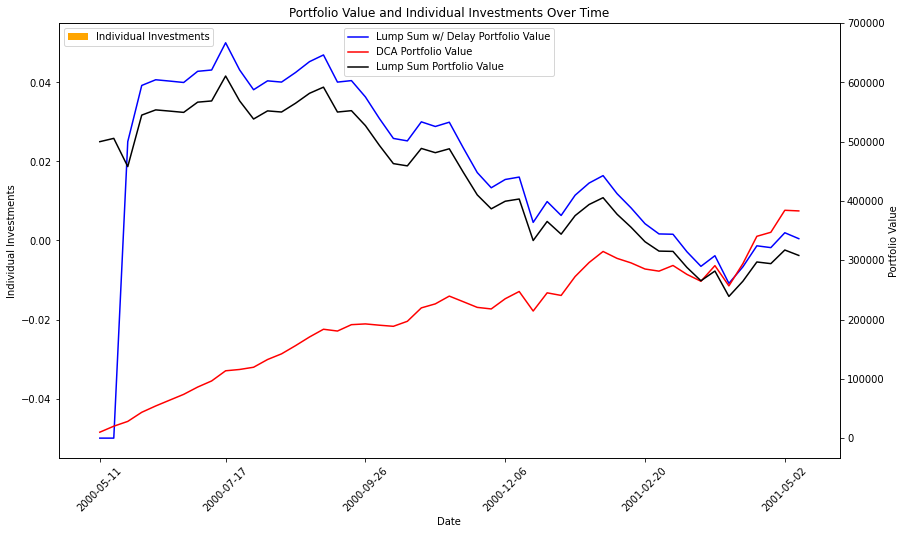

Initial Date : 2001-01-16
Start Date   : 2001-06-28 00:00:00
Lump Sum Date: 2002-01-16
End Date     : 2002-06-28


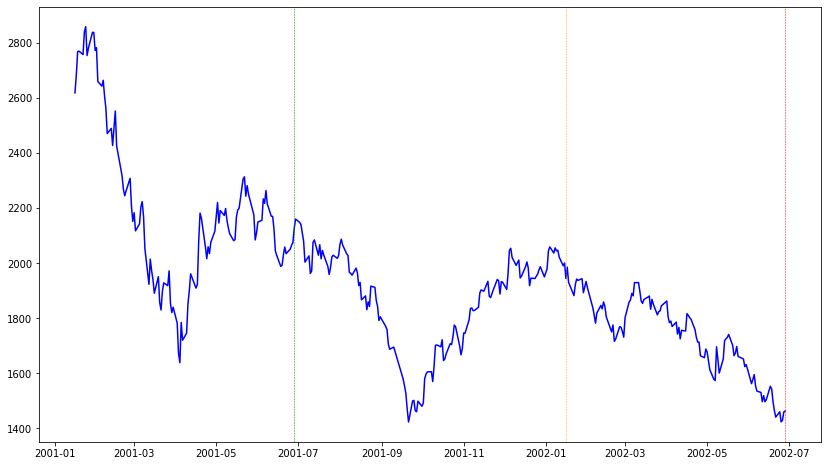

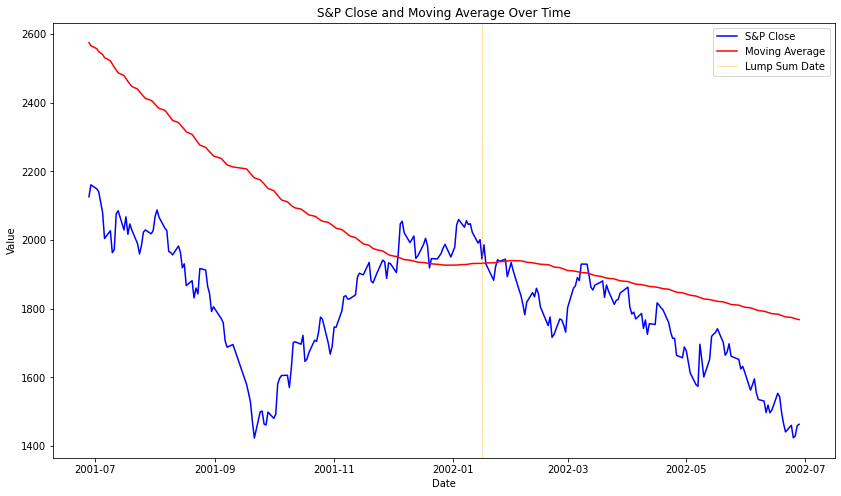

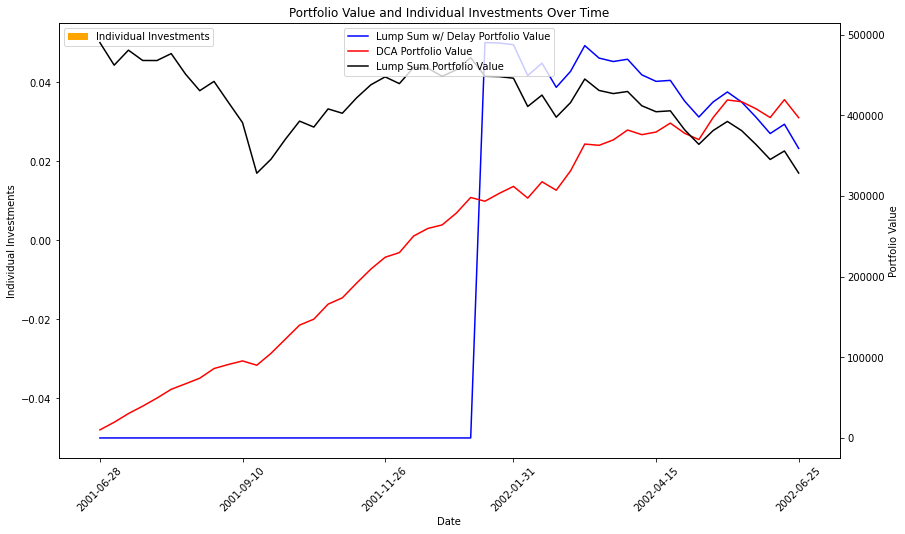

Initial Date : 1999-04-21
Start Date   : 2000-04-06 00:00:00
Lump Sum Date: 2000-04-20
End Date     : 2001-04-06


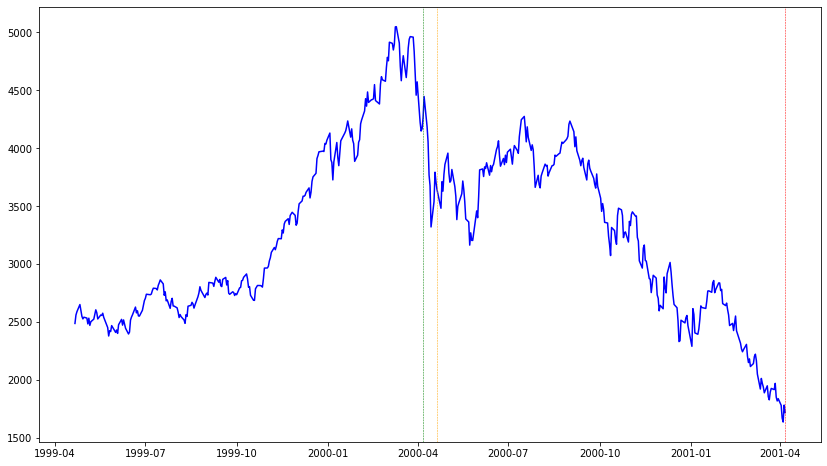

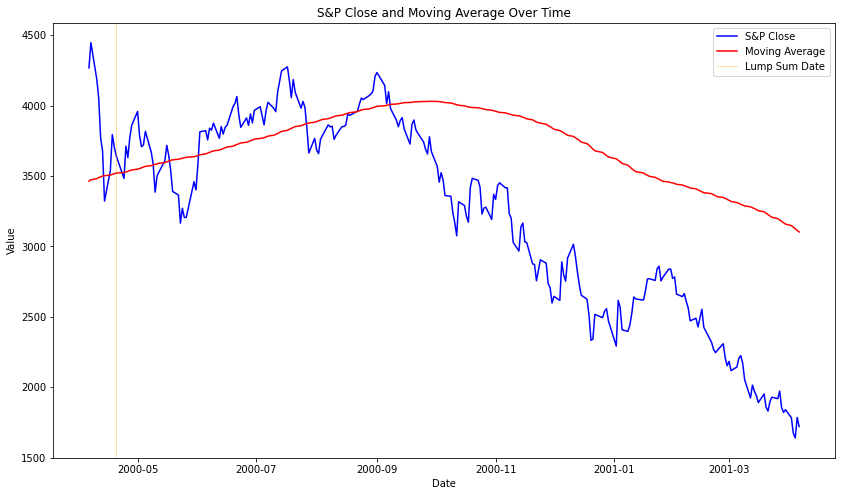

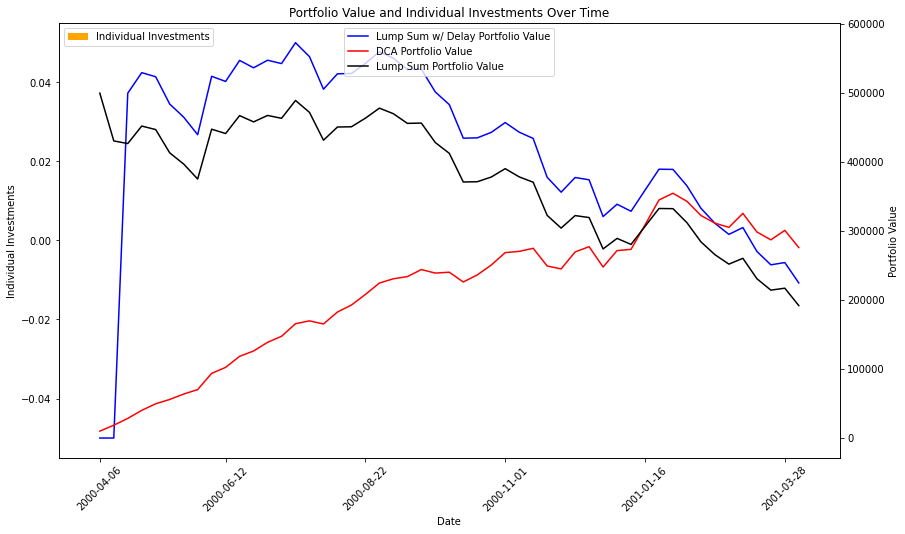

Initial Date : 2001-01-23
Start Date   : 2001-11-01 00:00:00
Lump Sum Date: 2002-01-23
End Date     : 2002-11-01


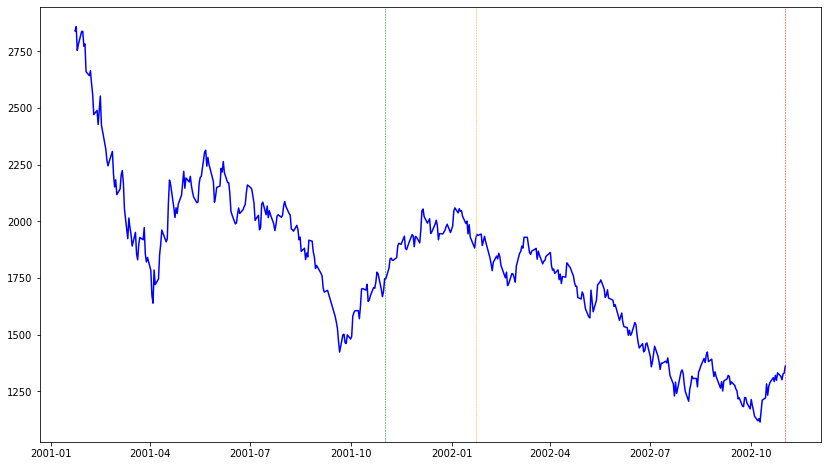

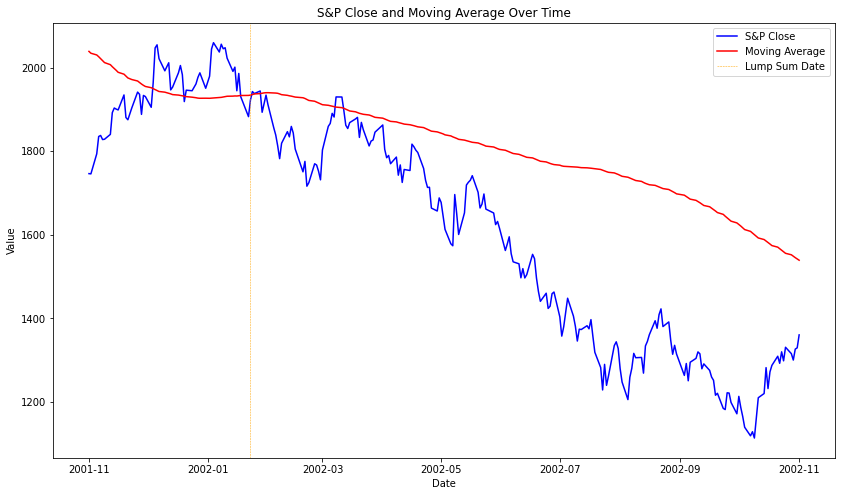

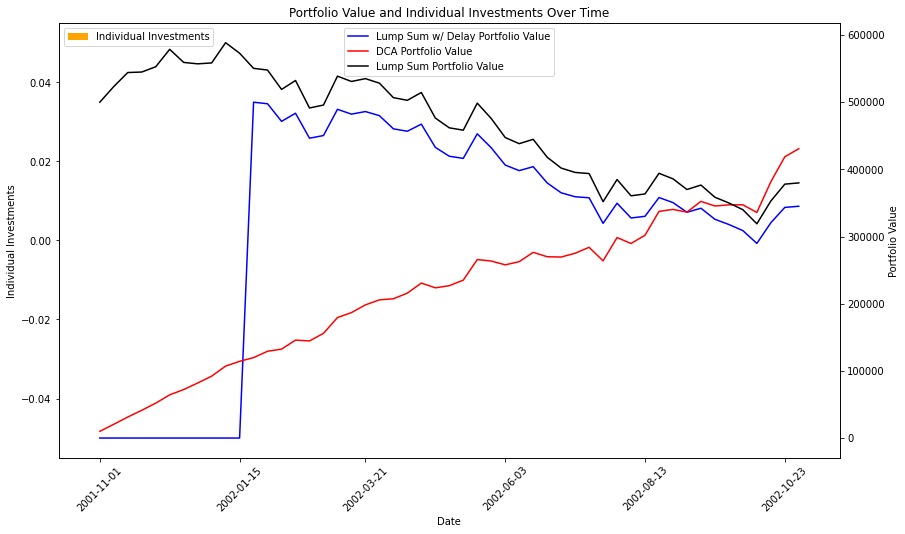

Initial Date : 1999-05-24
Start Date   : 2000-05-09 00:00:00
Lump Sum Date: 2000-05-23
End Date     : 2001-05-09


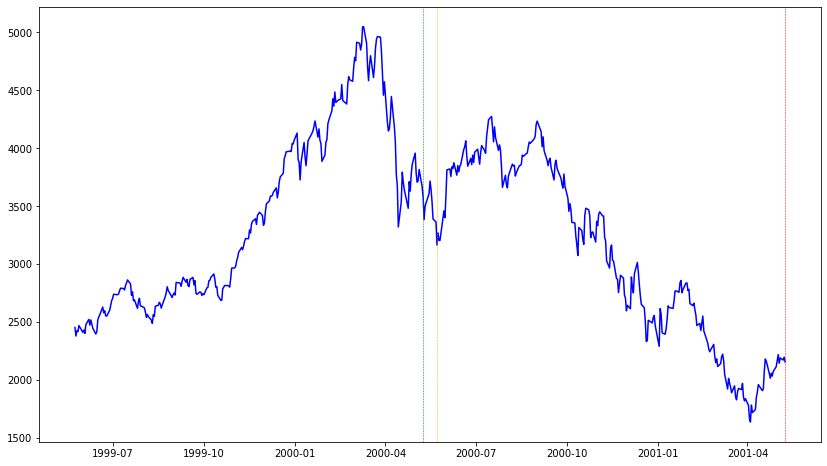

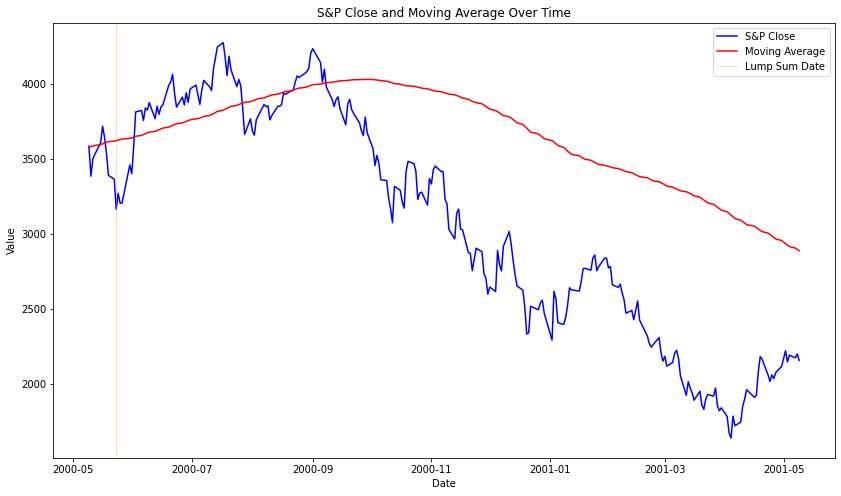

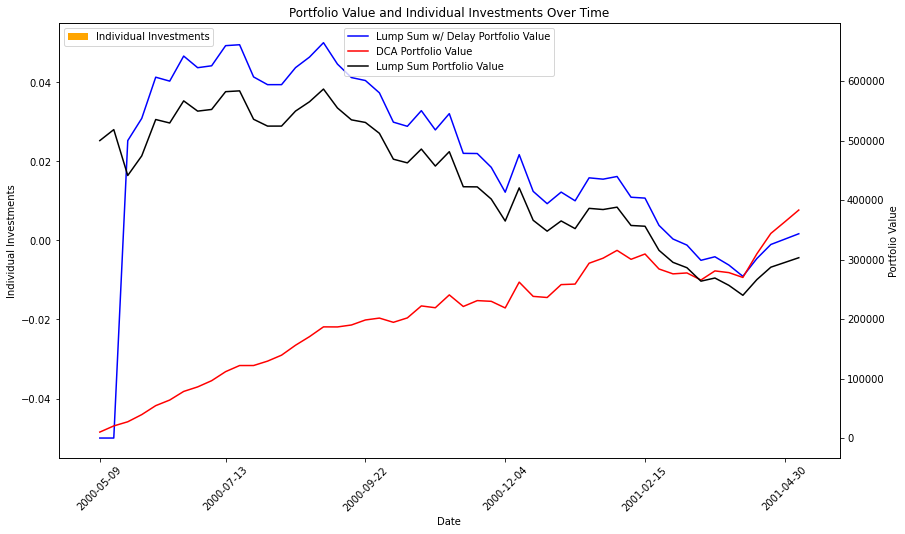

Initial Date : 2023-04-11
Start Date   : 2024-03-26 00:00:00
Lump Sum Date: 2024-04-10
End Date     : 2025-03-26


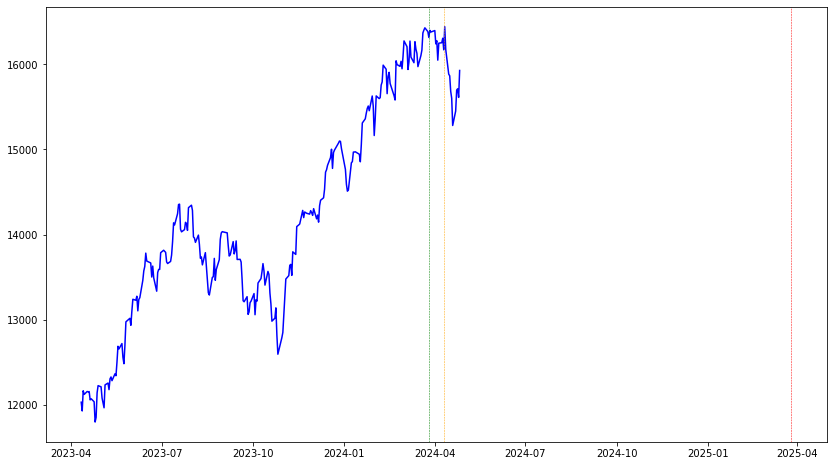

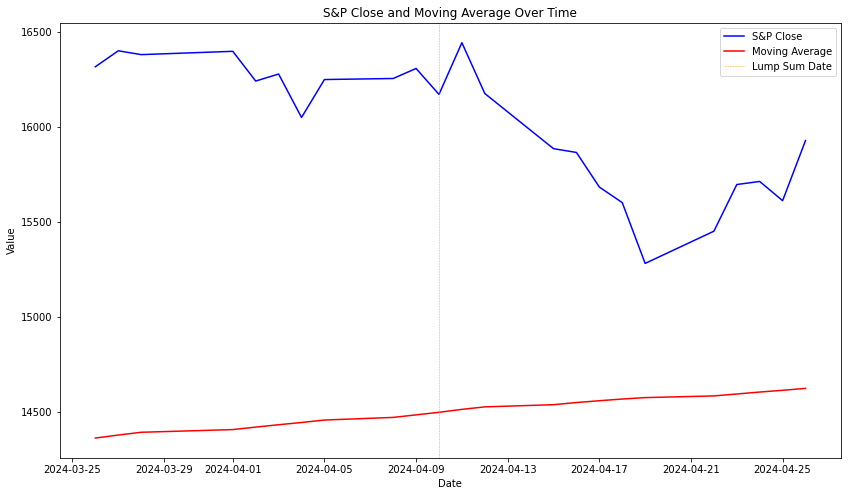

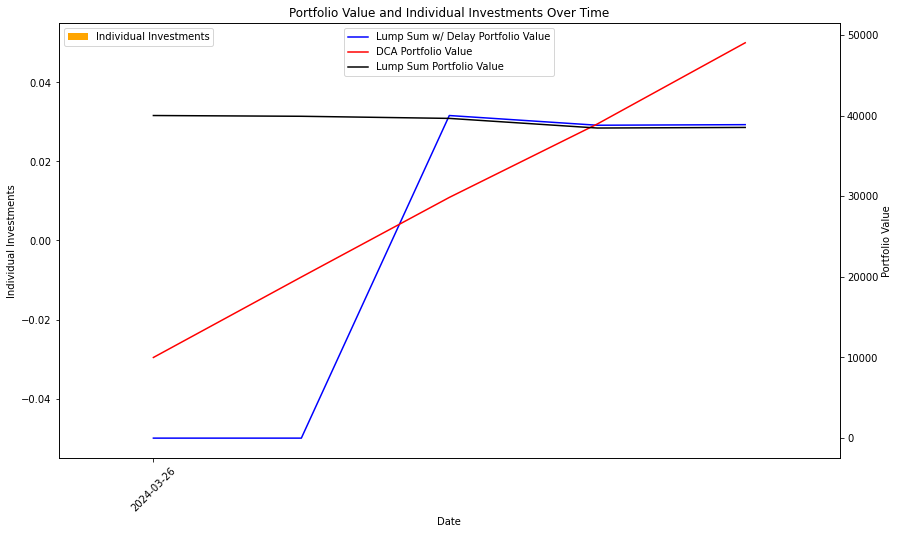

Initial Date : 2023-04-20
Start Date   : 2024-04-05 00:00:00
Lump Sum Date: 2024-04-19
End Date     : 2025-04-05


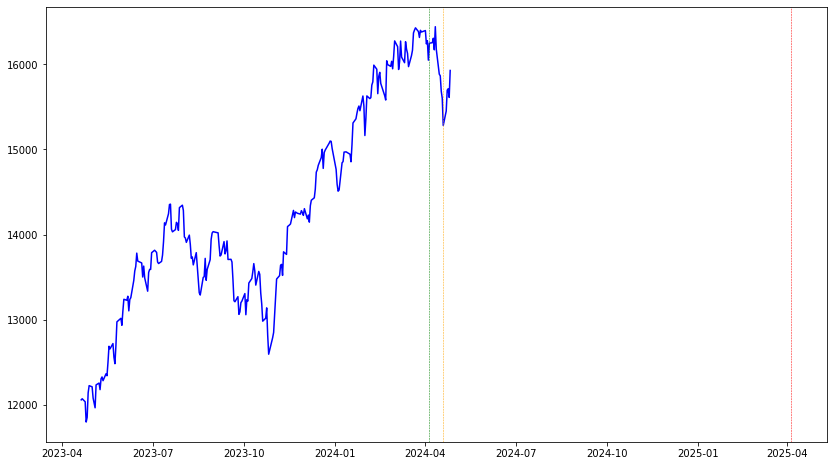

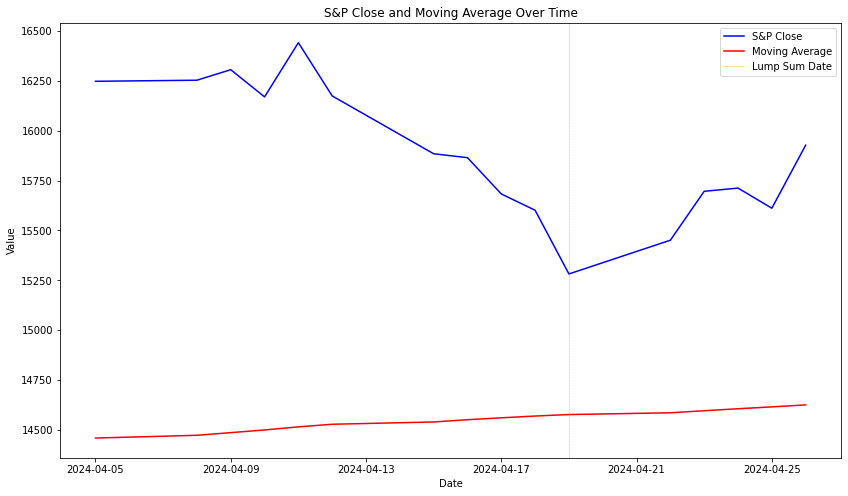

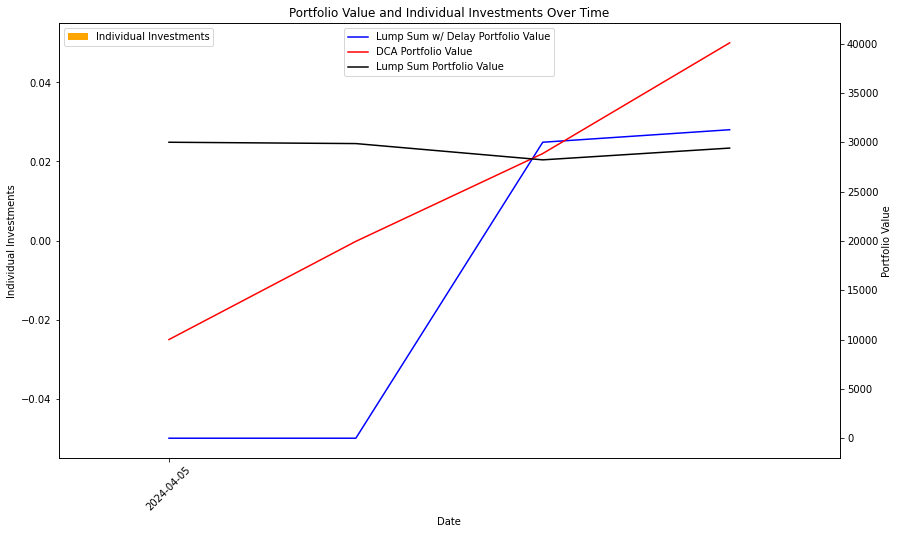

Initial Date : 2020-11-23
Start Date   : 2021-11-09 00:00:00
Lump Sum Date: 2021-11-23
End Date     : 2022-11-09


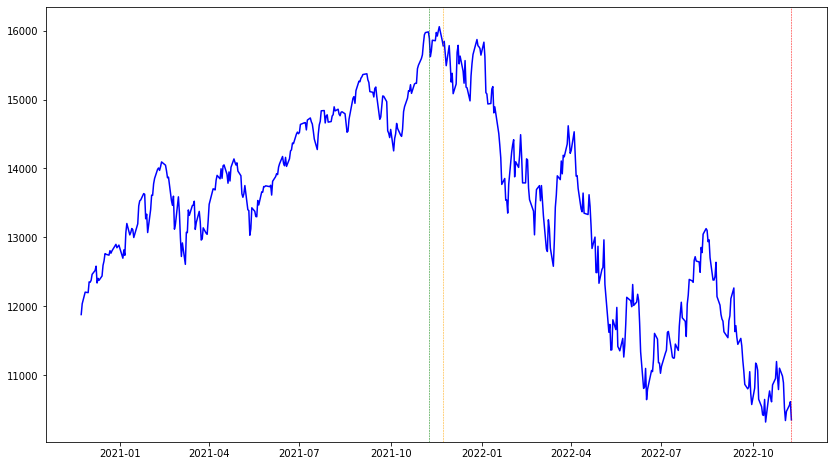

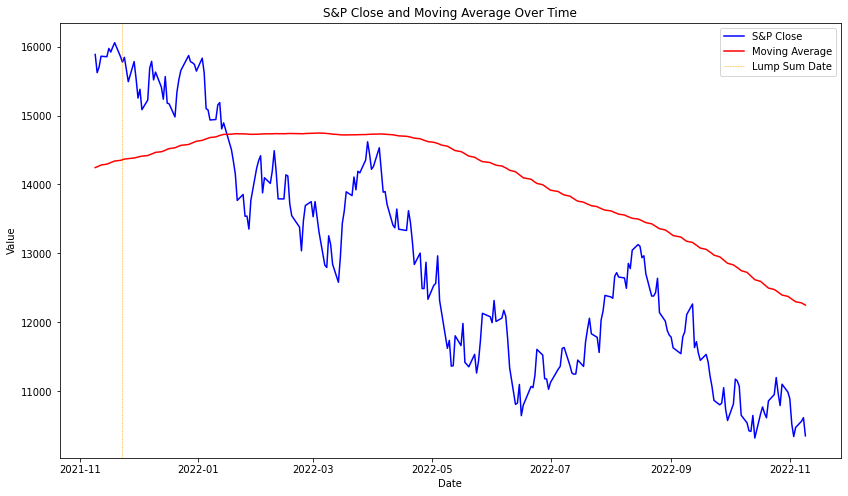

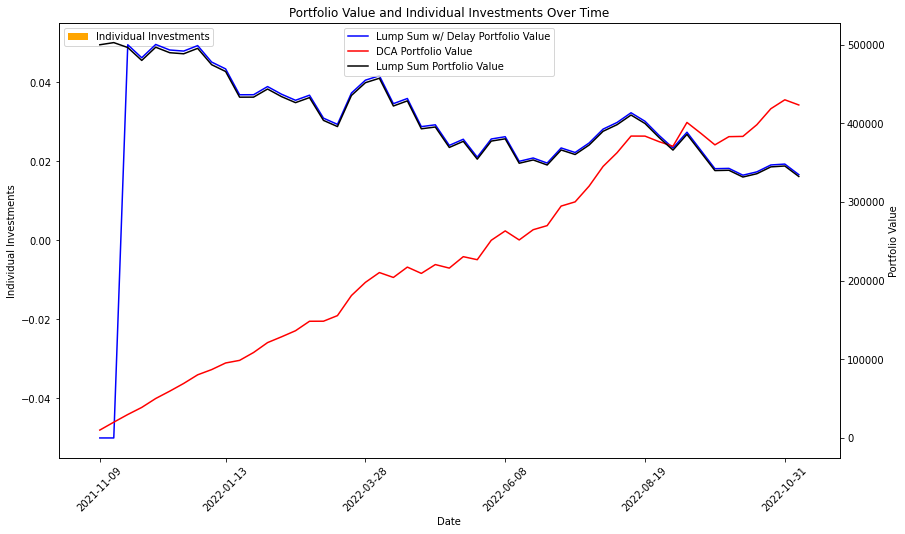

Initial Date : 2020-12-30
Start Date   : 2021-12-15 00:00:00
Lump Sum Date: 2021-12-30
End Date     : 2022-12-15


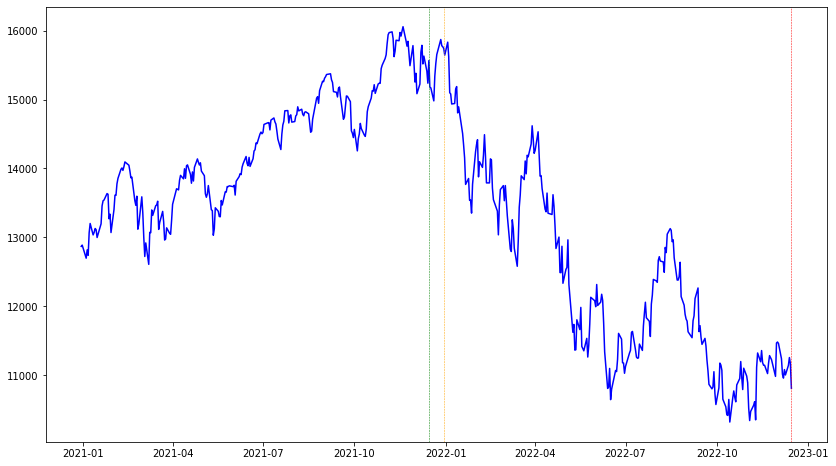

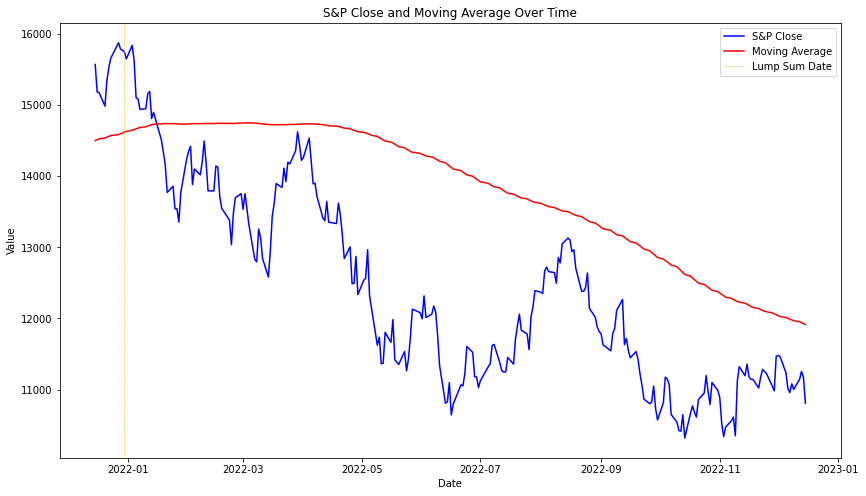

Initial Date : 1999-05-09
Start Date   : 2000-04-24 00:00:00
Lump Sum Date: 2000-05-08
End Date     : 2001-04-24


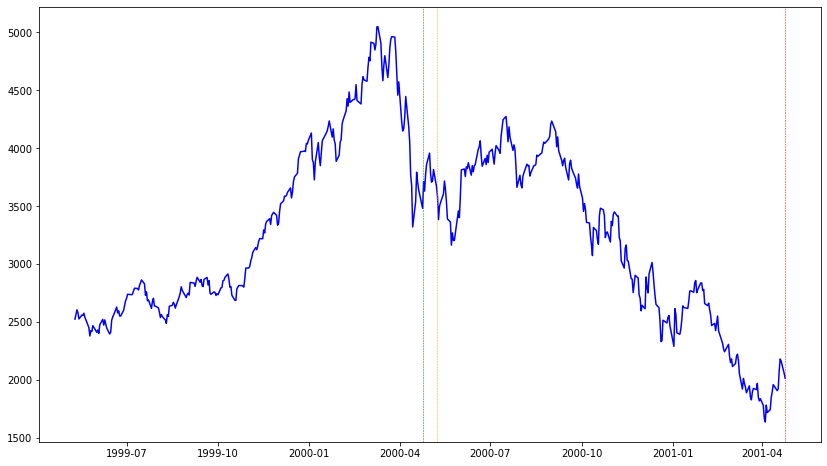

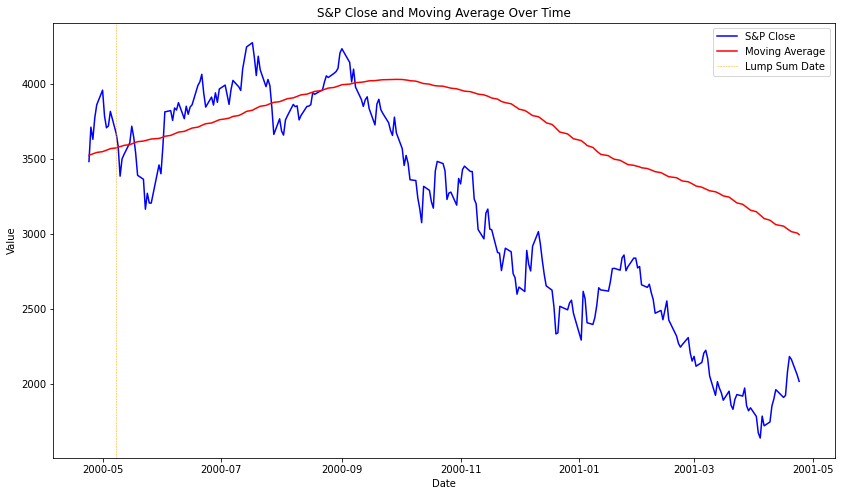

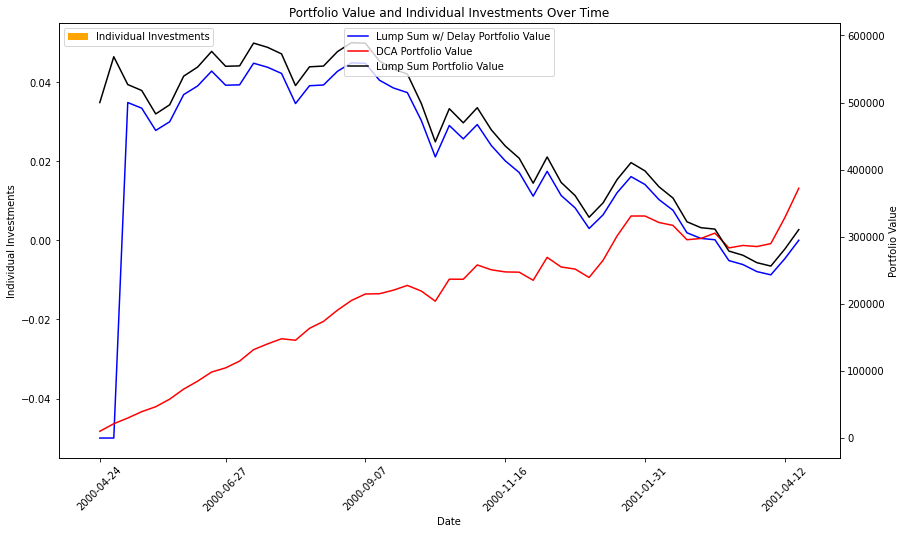

In [34]:
import matplotlib.pyplot as plt
from datetime import timedelta

start_dates = [results.loc[i]["Start Date"] for i in matching_delay_indices]
end_dates = [results.loc[i]["End Date"] for i in matching_delay_indices]
lump_sum_dates = [results.loc[i]["Lump Sum Date"] for i in matching_delay_indices]  # Extract lump sum dates
show_graph = True

for start_date, end_date, lump_sum_date in zip(start_dates, end_dates, lump_sum_dates):
    print("Initial Date :", (lump_sum_date - timedelta(days=365 * 1)).strftime('%Y-%m-%d'))
    print("Start Date   :", start_date)
    print("Lump Sum Date:", lump_sum_date.strftime('%Y-%m-%d'))
    print("End Date     :", end_date.strftime('%Y-%m-%d'))

    new_date = (lump_sum_date - timedelta(days=365 * 1))

    # Plot size
    plt.figure(figsize=(14, 8))

    # Plot S&P Close
    plt.plot(sandp_time['close'][new_date:end_date], label='S&P Close', color='blue')

    # Plot vertical lines for start_date, lump_sum_date, and end_date
    plt.axvline(x=start_date, color='green', linestyle='--', linewidth=0.5)
    plt.axvline(x=lump_sum_date, color='orange', linestyle='--', linewidth=0.5)
    plt.axvline(x=end_date, color='red', linestyle='--', linewidth=0.5)

    # Plotting DCA analysis
    result = dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val)

